# oviIN in comparison to other neurons in the fly brain
Where oviIN ranks in terms of number of synpatic partners, number of synaptic sites (pre and post), and number of neuropils it connects to. Import the preprocessed data from Hembrain v 1.2 that Alex compiled. It is a table containing the body ID of every traced neuron in the hemibrain along with other information. 

In [1]:
from neuprint import Client

auth_token_file = open("flybrain.auth.txt", 'r') # need file containing the authentication token
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
    np_client.fetch_version()
except:
    np_client = None

In [2]:
# import important stuff here
import numpy as np
import pandas as pd

In [3]:
# load package
import matplotlib
import matplotlib as mpl
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'MacOSX', etc.
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
%matplotlib inline

# turn off FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# turn off SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Set 'pdf.fonttype' to 42 to keep the text editable after exporting to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

In [4]:
# body IDs of oviINs from Neuprint
oviINr_bodyID = 423101189
oviINl_bodyID = 485934965

I used to read in the neuron data from Alex's preprocessed nodes but switched to using the traced-neurons.csv file from Hemibrain and fetching all neurons in case there is updated info to be fetched. Seems like there is no difference in the number of neurons at least.

In [5]:
# read the traced neurons csv for Hemibrain v1.2
df2 = pd.read_csv('data/exported-traced-adjacencies-v1.2/traced-neurons.csv')
df2

,bodyId,type,instance
0,200326126,CL141,CL141_L
1,202916528,FS4C,FS4C(FQ12)_C4_R
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R
3,203253253,SMP505,SMP505(PDM22)_L
4,203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...,...
21734,7112579856,LC20,LC20
21735,7112615127,AVLP335,AVLP335_R
21736,7112617294,AVLP331,AVLP331_R
21737,7112622044,LAL137,LAL137(PVL05)_L


As a sanity check, we get the same number of neurons when our criteria are Traced and not cropped. Without these criteria, there are 186,061 bodyIds which are probably mostly flotsom but it's good to know that we can mess with those if we want.

In [6]:
from neuprint import fetch_neurons, NeuronCriteria as NC
test,_ = fetch_neurons(NC(status='Traced', cropped=False))
test

,bodyId,instance,type,pre,post,downstream,upstream,mito,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,200326126,CL141_L,CL141,395,1068,4802,1068,274,827930581,Traced,False,Roughly traced,PDL20,251.0,"[3844, 14565, 15568]","{'SNP(R)': {'pre': 17, 'post': 19, 'downstream...",None,"[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","[AVLP(R), ICL(R), INP, LH(R), MB(+ACA)(R), PLP..."
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,776,431,84,235674230,Traced,False,Roughly traced,PDM03,301.0,"[20091, 12266, 12208]","{'SNP(L)': {'pre': 93, 'post': 35, 'downstream...",FB267SMP,"[CX, FB, FB-column3, FBl1, FBl2, FBl3, FBl4, F...","[CX, FB, FBl7, SMP(L), SNP(L)]"
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,426,366,45,154283963,Traced,False,Roughly traced,PDM03,236.0,"[17809, 10233, 14208]","{'SNP(L)': {'pre': 52, 'post': 30, 'downstream...",FB38ABSMP,"[AB(R), CRE(-RUB)(L), CRE(L), CX, FB, FB-colum...","[AB(R), CX, FB, FB-column3, FBl1, FBl7, FBl8, ..."
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,3195,3112,476,1763416504,Traced,False,Roughly traced,None,351.0,"[32168, 13757, 13336]","{'SNP(L)': {'pre': 150, 'post': 2282, 'downstr...",None,"[ATL(L), CRE(-RUB)(L), CRE(L), ICL(L), INP, SC...","[SIP(L), SIP(R), SLP(R), SMP(L), SMP(R), SNP(L..."
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,496,270,65,209983364,Traced,False,Roughly traced,PDM02,301.0,"[22758, 16749, 10240]","{'SNP(L)': {'pre': 65, 'post': 36, 'downstream...",FB267SMP,"[CX, FB, FBl1, FBl2, FBl3, FBl4, FBl5, FBl6, F...","[SIP(L), SMP(L), SNP(L)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633,2503,633,164,462394896,Traced,False,Roughly traced,None,301.5,"[7883, 23524, 33072]","{'OL(R)': {'pre': 268, 'post': 594, 'downstrea...",None,"[LO(R), OL(R), PLP(R), VLNP(R)]","[LO(R), OL(R), PLP(R), VLNP(R)]"
21735,7112615127,AVLP335_R,AVLP335,362,577,2666,577,157,453081149,Traced,False,Roughly traced,AVL13,NaN,None,"{'VLNP(R)': {'pre': 362, 'post': 577, 'downstr...",None,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]"
21736,7112617294,AVLP331_R,AVLP331,285,661,2080,661,137,438751734,Traced,False,Roughly traced,AVL13,NaN,None,"{'VLNP(R)': {'pre': 285, 'post': 661, 'downstr...",None,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]"
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087,11635,2087,534,1529252938,Traced,False,Roughly traced,None,NaN,None,"{'SNP(R)': {'pre': 304, 'post': 130, 'downstre...",VeLC-(LC)(c)Sm(b),"[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...","[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(..."


In [7]:
from neuprint import fetch_neurons
# fetch the all the traced neurons from Neuprint
neurons_df, roi_counts_df = fetch_neurons(df2['bodyId'].values)
neurons_df

,bodyId,instance,type,pre,post,downstream,upstream,mito,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,200326126,CL141_L,CL141,395,1068,4802,1068,274,827930581,Traced,False,Roughly traced,PDL20,251.0,"[3844, 14565, 15568]","{'SNP(R)': {'pre': 17, 'post': 19, 'downstream...",None,"[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","[AVLP(R), ICL(R), INP, LH(R), MB(+ACA)(R), PLP..."
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,776,431,84,235674230,Traced,False,Roughly traced,PDM03,301.0,"[20091, 12266, 12208]","{'SNP(L)': {'pre': 93, 'post': 35, 'downstream...",FB267SMP,"[CX, FB, FB-column3, FBl1, FBl2, FBl3, FBl4, F...","[CX, FB, FBl7, SMP(L), SNP(L)]"
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,426,366,45,154283963,Traced,False,Roughly traced,PDM03,236.0,"[17809, 10233, 14208]","{'SNP(L)': {'pre': 52, 'post': 30, 'downstream...",FB38ABSMP,"[AB(R), CRE(-RUB)(L), CRE(L), CX, FB, FB-colum...","[AB(R), CX, FB, FB-column3, FBl1, FBl7, FBl8, ..."
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,3195,3112,476,1763416504,Traced,False,Roughly traced,None,351.0,"[32168, 13757, 13336]","{'SNP(L)': {'pre': 150, 'post': 2282, 'downstr...",None,"[ATL(L), CRE(-RUB)(L), CRE(L), ICL(L), INP, SC...","[SIP(L), SIP(R), SLP(R), SMP(L), SMP(R), SNP(L..."
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,496,270,65,209983364,Traced,False,Roughly traced,PDM02,301.0,"[22758, 16749, 10240]","{'SNP(L)': {'pre': 65, 'post': 36, 'downstream...",FB267SMP,"[CX, FB, FBl1, FBl2, FBl3, FBl4, FBl5, FBl6, F...","[SIP(L), SMP(L), SNP(L)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633,2503,633,164,462394896,Traced,False,Roughly traced,None,301.5,"[7883, 23524, 33072]","{'OL(R)': {'pre': 268, 'post': 594, 'downstrea...",None,"[LO(R), OL(R), PLP(R), VLNP(R)]","[LO(R), OL(R), PLP(R), VLNP(R)]"
21735,7112615127,AVLP335_R,AVLP335,362,577,2666,577,157,453081149,Traced,False,Roughly traced,AVL13,NaN,None,"{'VLNP(R)': {'pre': 362, 'post': 577, 'downstr...",None,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]"
21736,7112617294,AVLP331_R,AVLP331,285,661,2080,661,137,438751734,Traced,False,Roughly traced,AVL13,NaN,None,"{'VLNP(R)': {'pre': 285, 'post': 661, 'downstr...",None,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]"
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087,11635,2087,534,1529252938,Traced,False,Roughly traced,None,NaN,None,"{'SNP(R)': {'pre': 304, 'post': 130, 'downstre...",VeLC-(LC)(c)Sm(b),"[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...","[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(..."


In [8]:
df = neurons_df

In [9]:
# replace the nan types with 'None' string
df['type'] = df['type'].fillna('None')

In [10]:
# naming convention function
def naming_neurons(df_n):
    """
    Function to rename the neurons based on instance and occurance. The function takes in a dataframe and finds the instance column. 
    For each row, we remove any chunks within parentheses but keep the _L or _R suffixes at the end. Then we check if the instance occurs more than once and add a (1) or (2) or (3) etc. suffix to the name.
    """
    df_neurons = df_n.copy()  # make a copy of the dataframe to avoid modifying the original
    # find index of rows where the instance is entirely within parentheses and remove the parentheses
    for index, row in df_neurons.iterrows():
        if str(row['instance']).startswith('(') and str(row['instance']).endswith(')'):
            df_neurons.at[index, 'instance'] = row['instance'][1:-1]
    df_neurons['name'] = df_neurons['instance'].str.replace(r'\s*\(.*?\)', '', regex=True)  # remove chunks within parentheses

    # see how many times each instance occurs greater than 1, filter out those that occur only once
    instance_counts = df_neurons['name'].value_counts()
    instance_counts = instance_counts[instance_counts > 1]
    #print(f"Instance counts:\n{instance_counts}\n")
    #display(df_neurons)

    # going through instance_counts, adding occurance suffixes to repeated instances
    for instance, count in instance_counts.items():
        
        # get the rows with the same instance
        rows = df_neurons[df_neurons['name'] == instance]

        # if there are multiple rows, add a suffix
        if len(rows) > 1: #checking if multiple rows
            for i in range(len(rows)): # iterating through the rows
                df_neurons.loc[rows.index[i], 'name'] += f'({i + 1})' # adding number based on index from isolated rows 
   
    return df_neurons

## Size
The size of every neuron in the brain listed in descending order.

In [11]:
size_neurons = df[['bodyId','instance','size','somaRadius']].sort_values(by='size',ascending=False,ignore_index=True).copy()
size_neurons

,bodyId,instance,size,somaRadius
0,5813050455,DNp32_R,25280916792,1341.000000
1,425790257,APL_R,23360457066,900.099976
2,1072063538,DNp27_R,16654541697,646.000000
3,5813105172,DPM_R,15191654896,681.000000
4,1807537598,HSE LPTC,12790165356,840.500000
...,...,...,...,...
21734,1077411306,MC61,21246830,NaN
21735,1934482795,LPC2,21241958,NaN
21736,1046385084,MC61,20901051,NaN
21737,1963803666,LPC2,18975744,NaN


oviIN is not the largest neuron but it ranks as the 16th largest out of 21,739 so it is up there. APL is 2nd largest, lLN2f_bs are 18th and 19th largest. The right DPM is 4th largest.

In [12]:
size_neurons.loc[size_neurons['bodyId']==oviINr_bodyID]

,bodyId,instance,size,somaRadius
15,423101189,oviIN_R,10033593370,NaN


In [13]:
size_neurons.head(20)

,bodyId,instance,size,somaRadius
0,5813050455,DNp32_R,25280916792,1341.000000
1,425790257,APL_R,23360457066,900.099976
2,1072063538,DNp27_R,16654541697,646.000000
3,5813105172,DPM_R,15191654896,681.000000
4,1807537598,HSE LPTC,12790165356,840.500000
5,2124762952,mALC2_L,12642223789,241.500000
6,1497973422,AMMC-A1_R,12500596539,365.000000
7,262840563,OCG01,12489936696,486.000000
8,5813070019,AMMC-A1_R,11740731985,645.500000
9,1311993208,CT1_L,11629295267,945.000000


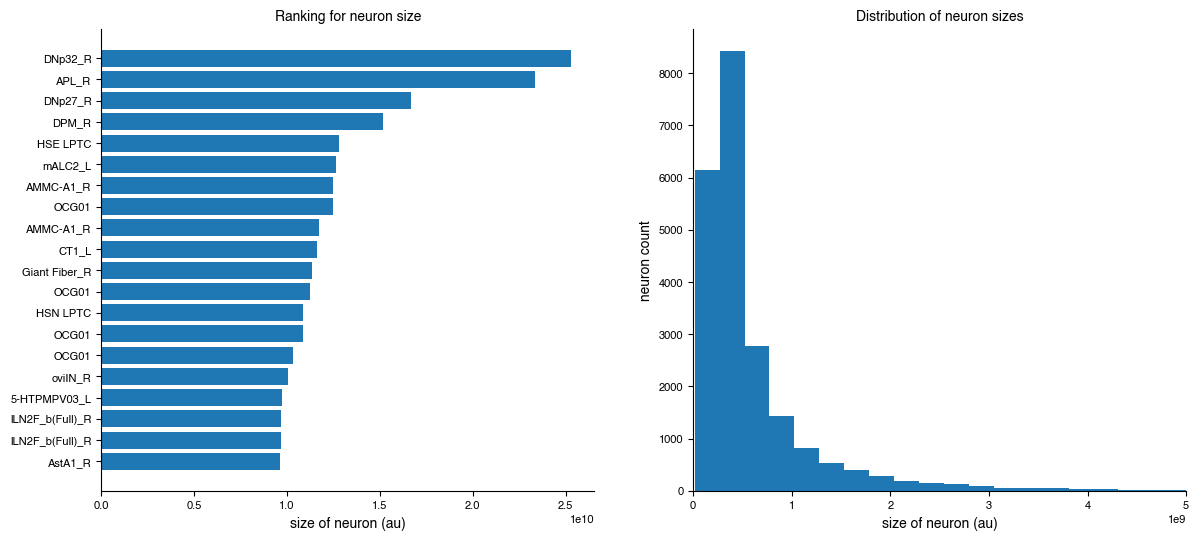

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(size_neurons.head(nn)))
performance = size_neurons['size'].head(nn)

# preparing names for the y-axis
size_neurons_labels = naming_neurons(size_neurons)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=size_neurons_labels['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('size of neuron (au)')
ax[0].set_title('Ranking for neuron size')

ax[1].hist(size_neurons['size'],bins=100)
ax[1].set_xlabel('size of neuron (au)')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of neuron sizes')
ax[1].set_xlim(0,0.5e10)

plt.show()

oviIN's soma radius is not available in the current data.

In [15]:
somaSize = size_neurons.sort_values(by='somaRadius',ascending=False,ignore_index=True)
somaSize.loc[somaSize['bodyId']==oviINr_bodyID]

,bodyId,instance,size,somaRadius
16804,423101189,oviIN_R,10033593370,NaN


In [16]:
somaSize.head(10)

,bodyId,instance,size,somaRadius
0,5813050455,DNp32_R,25280916792,1341.000000
1,1575852343,CT1(AVM19)_R,6303385952,1329.000000
2,1135837629,DSKMP1A_R,9376851530,1116.000000
3,1260833150,DSKMP1A(PVM02)_L,6972520893,1010.500000
4,1884625521,l-LNv,3531576662,995.000000
5,1714172947,Am1? LOP-LO,2750045253,990.500000
6,1352077058,DSKMP1B_R,5492683352,955.000000
7,5813027248,aMe17a,4056415219,947.000000
8,1311993208,CT1_L,11629295267,945.000000
9,425790257,APL_R,23360457066,900.099976


# Partners 

## Obtain partner data for all Hemibrain neurons
This section obtains the number of pre and post synaptic partners and cell types for every neuron in the brain.

In [11]:
all_neurons = df[['bodyId','instance','type','pre','post']].copy()

In [12]:
all_neurons

,bodyId,instance,type,pre,post
0,200326126,CL141_L,CL141,395,1068
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366
3,203253253,SMP505(PDM22)_L,SMP505,415,3112
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270
...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633
21735,7112615127,AVLP335_R,AVLP335,362,577
21736,7112617294,AVLP331_R,AVLP331,285,661
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087


Only run the next block for testing the for loop on only 10 neurons.

In [19]:
# for testing a small chunk
all_neurons = all_neurons.head(n=10)
all_neurons

,bodyId,instance,type,pre,post
0,200326126,CL141_L,CL141,395,1068
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366
3,203253253,SMP505(PDM22)_L,SMP505,415,3112
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270
5,203594169,FS4A(AB)(FQ12)_C4_R,FS4A,45,292
6,203594175,FS4A(AB)(FQ12)_C4_R,FS4A,57,346
7,203598499,FB8H_L,FB8H,289,633
8,203598504,FS4A(FQ12)_C5_R,FS4A,39,194
9,203598542,FS4B(FQ12)_C4_R,FS4B,57,341


This will take a long time to run on all the neurons (~100 minutes). Be prepared. This was tested on a small chunk of all_neurons and the results were cross-validated with the neuprint site.

In [20]:
from neuprint import fetch_simple_connections

all_IDs = list(all_neurons['bodyId'])
weight_threshold = 3

# note that fetch_simple_connections only returns connections with Traced neurons

for bodyID in all_IDs:
    # get the pre-syn partners to neuron and count them up
    inputs = fetch_simple_connections(None, bodyID, min_weight=weight_threshold)
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_pre_partners']] = inputs['bodyId_pre'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_pre_types']] = inputs['type_pre'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['input_weights']] = inputs['weight'].sum()
    
    # get the post-syn partners to neuron and count them up
    outputs = fetch_simple_connections(bodyID, None, min_weight=weight_threshold)
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_post_partners']] = outputs['bodyId_post'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_post_types']] = outputs['type_post'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['output_weights']] = outputs['weight'].sum()
    
    # combine input and output bodyIDs and count up total unique synaptic partners
    all_partners = pd.concat([inputs['bodyId_pre'],outputs['bodyId_post']])
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_total_partners']] = all_partners.nunique()

    # combine input and output types and count up total unique synaptic partner types
    all_types = pd.concat([inputs['type_pre'],outputs['type_post']])
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_total_types']] = all_types.nunique()

    #combine input and output weights and count up total synaptic weights
    all_weights = inputs['weight'].sum() + outputs['weight'].sum()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['total_weights']] = all_weights
    
#all_neurons['n_pre_partners'] = all_neurons['n_pre_partners'].astype(int)
#all_neurons['n_post_partners'] = all_neurons['n_post_partners'].astype(int)
#all_neurons['n_total_partners'] = all_neurons['n_total_partners'].astype(int)
#all_neurons['n_pre_types'] = all_neurons['n_pre_types'].astype(int)
#all_neurons['n_post_types'] = all_neurons['n_post_types'].astype(int)
#all_neurons['n_total_types'] = all_neurons['n_total_types'].astype(int)
#all_neurons['input_weights'] = all_neurons['input_weights'].astype(int)
#all_neurons['output_weights'] = all_neurons['output_weights'].astype(int)
#all_neurons['total_weights'] = all_neurons['total_weights'].astype(int)
all_neurons

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,200326126,CL141_L,CL141,395,1068,60.0,44.0,657.0,112.0,80.0,841.0,163.0,115.0,1498.0
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,40.0,21.0,228.0,50.0,12.0,305.0,90.0,33.0,533.0
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,41.0,23.0,187.0,26.0,7.0,131.0,64.0,27.0,318.0
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,271.0,59.0,2396.0,92.0,45.0,819.0,345.0,92.0,3215.0
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,28.0,17.0,139.0,33.0,7.0,186.0,60.0,24.0,325.0
5,203594169,FS4A(AB)(FQ12)_C4_R,FS4A,45,292,29.0,17.0,129.0,19.0,4.0,109.0,45.0,18.0,238.0
6,203594175,FS4A(AB)(FQ12)_C4_R,FS4A,57,346,33.0,16.0,159.0,19.0,5.0,102.0,48.0,19.0,261.0
7,203598499,FB8H_L,FB8H,289,633,74.0,18.0,389.0,126.0,19.0,931.0,185.0,30.0,1320.0
8,203598504,FS4A(FQ12)_C5_R,FS4A,39,194,14.0,7.0,88.0,17.0,2.0,90.0,31.0,9.0,178.0
9,203598542,FS4B(FQ12)_C4_R,FS4B,57,341,25.0,17.0,152.0,26.0,6.0,151.0,50.0,22.0,303.0


In [21]:
# replace None with string
all_neurons = all_neurons.fillna('None')

In [22]:
# save this in the oviIN_specs folder
#all_neurons.to_csv('data/all_neurons_n_partners.csv')

In [13]:
# to load the saved dataframe of all_neurons
all_neurons = pd.read_csv('data/all_neurons_n_partners.csv', index_col=0)

## Synaptic partner rankings for quantity of neurons and types
### ranking for presynaptic partners

With a weight threshold of 3 or greater synapses, oviIN ranks 23rd for the most pre-synaptic partners. APL is 1st, lLN2F_bs are 6th and 9th, DPMs are 2nd and 3rd.
With no weight threshold, oviIN ranks 14th for the most pre-synaptic partners. APL is 2nd, lLN2F_bs are 4th and 7th, DPM is 15th.

In [14]:
# sorting by the number of pre-synaptic partners and finding where oviIN ranks
pre_partner_rank = all_neurons.sort_values(by='n_pre_partners',ascending=False,ignore_index=True)
pre_partner_rank.loc[pre_partner_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
22,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0


In [15]:
pre_partner_rank.head(15)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0
1,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0
2,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
3,424789697,MBON02(B2B'2a)_R,MBON02,1155,19554,2044.0,46.0,18105.0,155.0,108.0,2828.0,2171.0,132.0,20933.0
4,5813022341,MBON02(B2B'2a)_L,MBON02,99,17937,1985.0,23.0,16718.0,22.0,8.0,111.0,1987.0,24.0,16829.0
5,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
6,2124762952,mALC2_L,mALC2,7281,20985,1693.0,75.0,16161.0,1610.0,97.0,12356.0,3019.0,126.0,28517.0
7,424767514,MBON11(y1pedc>a/B)_R,MBON11,1646,27642,1644.0,45.0,26016.0,234.0,113.0,4796.0,1833.0,130.0,30812.0
8,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0
9,393766777,PPL101(y1pedc)_R,PPL101,2197,16276,1550.0,206.0,14349.0,719.0,97.0,5156.0,1640.0,246.0,19505.0


In [16]:
# summary stats
pre_partner_rank['n_pre_partners'].describe()

count    21739.000000
mean        66.154469
std         98.797726
min          0.000000
25%         20.000000
50%         43.000000
75%         74.000000
max       2666.000000
Name: n_pre_partners, dtype: float64

In [17]:
# running partners dataframe through the naming function
pre_partner_rank_test = naming_neurons(pre_partner_rank.head(15))
pre_partner_rank_test

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights,name
0,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0,APL_R
1,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0,DPM_L
2,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0,DPM_R
3,424789697,MBON02(B2B'2a)_R,MBON02,1155,19554,2044.0,46.0,18105.0,155.0,108.0,2828.0,2171.0,132.0,20933.0,MBON02_R
4,5813022341,MBON02(B2B'2a)_L,MBON02,99,17937,1985.0,23.0,16718.0,22.0,8.0,111.0,1987.0,24.0,16829.0,MBON02_L
5,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0,lLN2F_b_R(1)
6,2124762952,mALC2_L,mALC2,7281,20985,1693.0,75.0,16161.0,1610.0,97.0,12356.0,3019.0,126.0,28517.0,mALC2_L
7,424767514,MBON11(y1pedc>a/B)_R,MBON11,1646,27642,1644.0,45.0,26016.0,234.0,113.0,4796.0,1833.0,130.0,30812.0,MBON11_R
8,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0,lLN2F_b_R(2)
9,393766777,PPL101(y1pedc)_R,PPL101,2197,16276,1550.0,206.0,14349.0,719.0,97.0,5156.0,1640.0,246.0,19505.0,PPL101_R


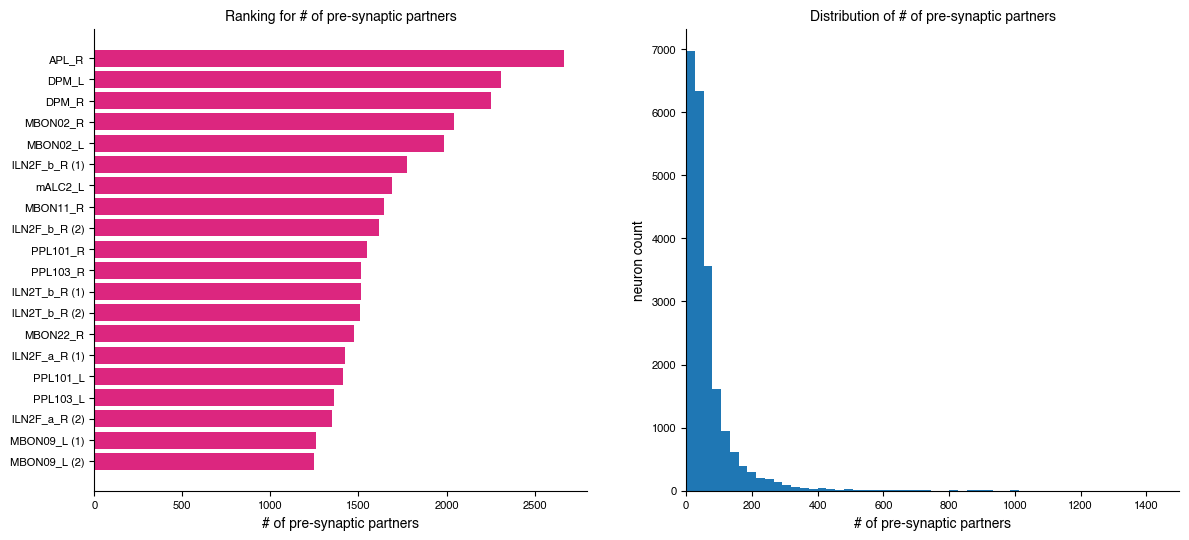

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(pre_partner_rank.head(nn)))
performance = pre_partner_rank['n_pre_partners'].head(nn)

# change naming convention for the neurons
pre_partner_rank_labels = naming_neurons(pre_partner_rank.head(nn))

ax[0].barh(y_pos, performance, align='center',color=colors[1])
ax[0].set_yticks(y_pos, labels=pre_partner_rank_labels['name']) # using new naming convention
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of pre-synaptic partners')
ax[0].set_title('Ranking for # of pre-synaptic partners')

ax[1].hist(pre_partner_rank['n_pre_partners'],bins=100)
ax[1].set_xlabel('# of pre-synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of pre-synaptic partners')
ax[1].set_xlim(0,1500)

plt.show()

### ranking for postsynaptic partners
With a weight threshold of 3 or greater synapses, oviIN ranks 5th for the most post-synaptic partners. APL is 1st, lLN2F_bs are 6th and 8th, DPMs are 2nd and 4th.
With no weight threshold, oviINr ranks 10th for the most post-synaptic partners. APL is 16th, lLN2F_bs are 15th and 21st, DPMs are 17th and 24th.

In [18]:
# sorting by the number of post-synaptic partners and finding where oviIN ranks
post_partner_rank = all_neurons.sort_values(by='n_post_partners',ascending=False,ignore_index=True)
post_partner_rank.loc[post_partner_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
4,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0


In [30]:
post_partner_rank.loc[post_partner_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0


In [31]:
post_partner_rank.loc[post_partner_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
5,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
7,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0


In [32]:
post_partner_rank.loc[post_partner_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
3,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0


In [33]:
post_partner_rank.head(15)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0
1,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
2,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,743.0,338.0,6290.0,2264.0,975.0,17465.0,2501.0,1038.0,23755.0
3,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0
4,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0
5,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
6,485934965,oviIN_L,oviIN,6542,15998,1030.0,287.0,13388.0,1849.0,583.0,22535.0,2332.0,668.0,35923.0
7,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0
8,2124762952,mALC2_L,mALC2,7281,20985,1693.0,75.0,16161.0,1610.0,97.0,12356.0,3019.0,126.0,28517.0
9,5813022424,PPL103(y2a'1)_R,PPL103,3375,15227,1515.0,191.0,13172.0,1340.0,44.0,13070.0,1733.0,201.0,26242.0


In [34]:
# summary stats
post_partner_rank['n_post_partners'].describe()

count    21739.000000
mean        60.197663
std         86.714992
min          0.000000
25%         22.000000
50%         41.000000
75%         67.000000
max       2527.000000
Name: n_post_partners, dtype: float64

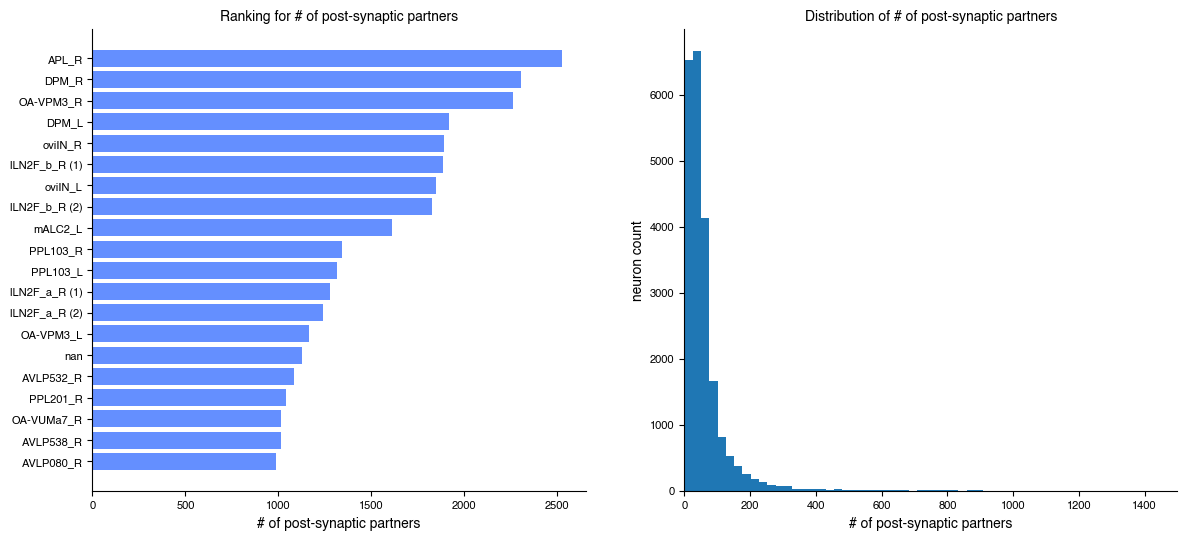

In [35]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20
# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(post_partner_rank.head(nn)))
performance = post_partner_rank['n_post_partners'].head(nn)

# change naming convention for the neurons
post_partner_rank_labels = naming_neurons(post_partner_rank.head(nn))

ax[0].barh(y_pos, performance, align='center',color=colors[0])
ax[0].set_yticks(y_pos, labels=post_partner_rank_labels['name'])
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of post-synaptic partners')
ax[0].set_title('Ranking for # of post-synaptic partners')

ax[1].hist(post_partner_rank['n_post_partners'],bins=100)
ax[1].set_xlabel('# of post-synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of post-synaptic partners')
ax[1].set_xlim(0,1500)

plt.show()

### ranking for total number of synaptic partners
Without weight thresholds, oviINr ranks 7th for total number of unique synaptic partners and oviINl is right behind it. Interestingly, DPM and APL are not in the top ten. APL is 21st, DPMs are 24th and 59th, lLN2F_bs are 16th and 25th. This is striking because it indicates that oviIN is communnicating with a broad range of neurons.
With a weight threshold of 3 or greater synapses, oviIN ranks 5th for the most partners. APL is 2nd, lLN2F_bs are 7th and 9th, DPMs are 4th and 6th.

In [19]:
# sorting by the number of total unique synaptic partners and finding where oviIN ranks
total_partner_rank = all_neurons.sort_values(by='n_total_partners',ascending=False,ignore_index=True)
total_partner_rank.loc[total_partner_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
4,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0


In [20]:
total_partner_rank.head(10)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,2124762952,mALC2_L,mALC2,7281,20985,1693.0,75.0,16161.0,1610.0,97.0,12356.0,3019.0,126.0,28517.0
1,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0
2,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,743.0,338.0,6290.0,2264.0,975.0,17465.0,2501.0,1038.0,23755.0
3,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0
4,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0
5,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
6,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
7,485934965,oviIN_L,oviIN,6542,15998,1030.0,287.0,13388.0,1849.0,583.0,22535.0,2332.0,668.0,35923.0
8,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0
9,424789697,MBON02(B2B'2a)_R,MBON02,1155,19554,2044.0,46.0,18105.0,155.0,108.0,2828.0,2171.0,132.0,20933.0


In [21]:
# summary stats
total_partner_rank['n_total_partners'].describe()

count    21739.000000
mean       110.721606
std        138.489111
min          0.000000
25%         44.000000
50%         76.000000
75%        123.000000
max       3019.000000
Name: n_total_partners, dtype: float64

In [22]:
total_partner_rank.loc[total_partner_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
6,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
8,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0


In [23]:
# compute the average number of synaptic partners per neuron
total_partner_rank.loc[total_partner_rank['type']=='lLN2F_b']['n_total_partners'].mean()

2263.5

In [24]:
# compute the average number of synaptic partner types per neuron
total_partner_rank.loc[total_partner_rank['type']=='lLN2F_b']['n_total_types'].mean()

218.5

In [25]:
total_partner_rank.loc[total_partner_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0


In [26]:
total_partner_rank.loc[total_partner_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
3,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0
5,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0


In [27]:
# compute the average number of synaptic partners per neuron
total_partner_rank.loc[total_partner_rank['type']=='DPM']['n_total_partners'].mean()

2411.0

In [28]:
total_partner_rank['n_total_partners'].describe()

count    21739.000000
mean       110.721606
std        138.489111
min          0.000000
25%         44.000000
50%         76.000000
75%        123.000000
max       3019.000000
Name: n_total_partners, dtype: float64

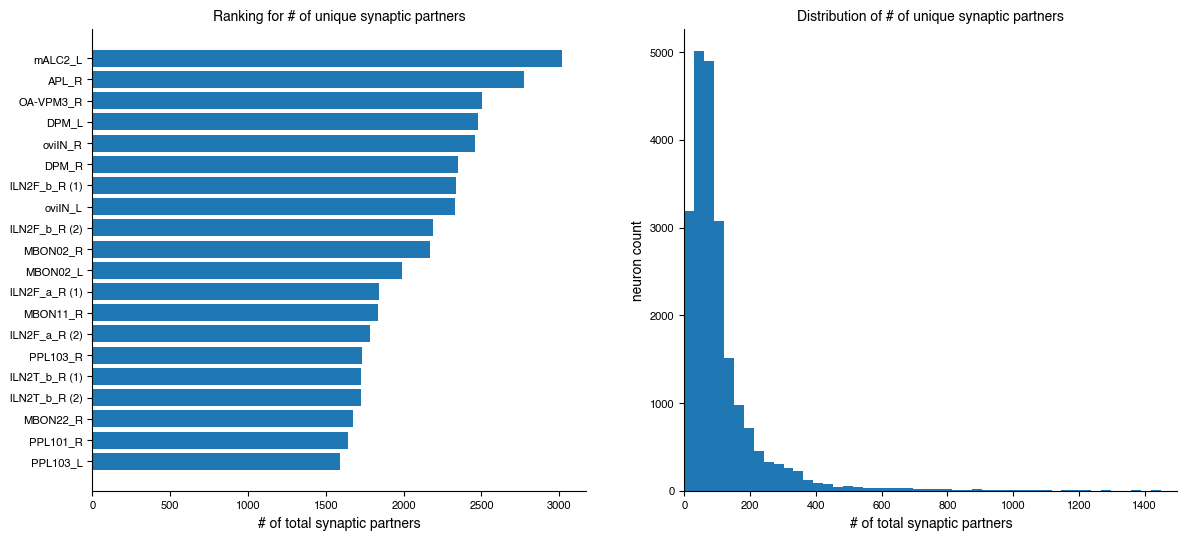

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_partner_rank.head(nn)))
performance = total_partner_rank['n_total_partners'].head(nn)

# change naming convention for the neurons
total_partner_rank_labels = naming_neurons(total_partner_rank.head(nn))

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=total_partner_rank_labels['name'])
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of total synaptic partners')
ax[0].set_title('Ranking for # of unique synaptic partners')

ax[1].hist(total_partner_rank['n_total_partners'],bins=100)
ax[1].set_xlabel('# of total synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of unique synaptic partners')
ax[1].set_xlim(0,1500)

#plt.savefig('figures/total_partners_rank_hbar_hist.pdf', format='pdf')
plt.show()

Creating a figure that combines pre and post partners in a stacked bar chart.  This bar chart takes into account synaptic partners that are both pre and post to the neuron.

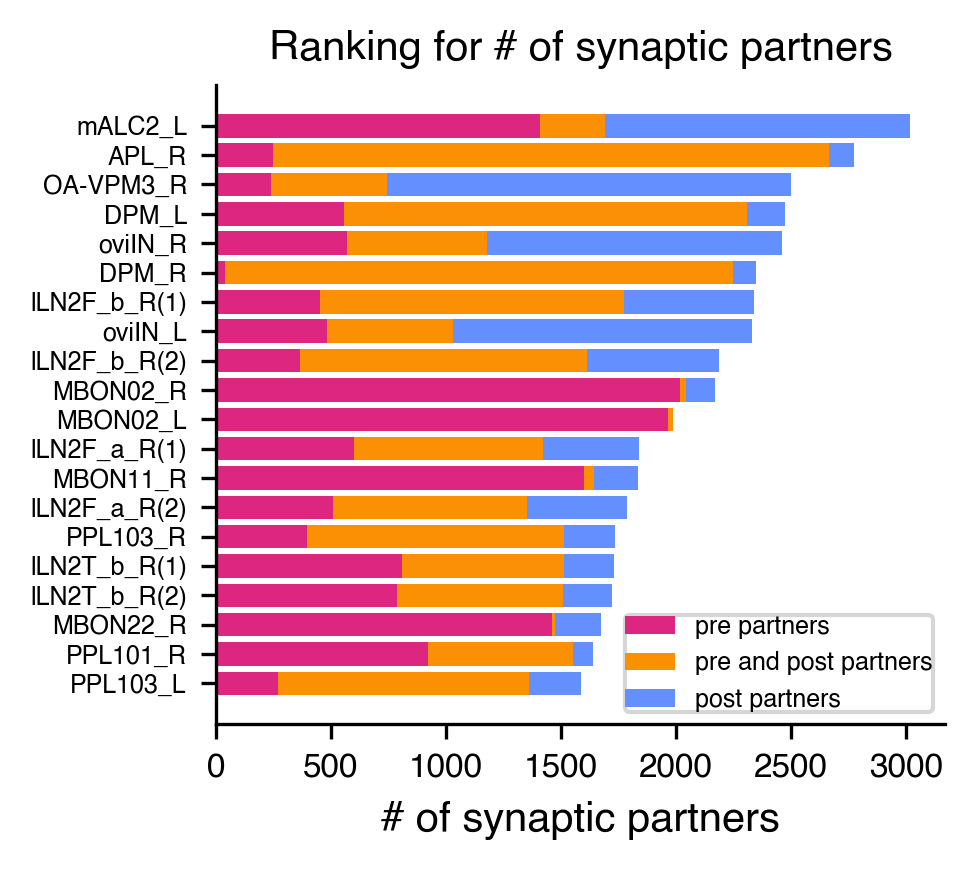

In [29]:
import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots(1,2,figsize=(14,6))
fig, ax = plt.subplots(figsize=(3.35, 3), dpi=300, tight_layout='tight')
#fig = plt.figure(figsize=(3.35, 3), dpi=300, tight_layout='tight')
#ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])  # [left, bottom, width, height]
nn = 20

# grab the data
y_pos = np.arange(len(total_partner_rank.head(nn)))
tuniquep = total_partner_rank['n_total_partners'].head(nn)
postp = total_partner_rank['n_post_partners'].head(nn)
prep = total_partner_rank['n_pre_partners'].head(nn)

# change naming convention for the neurons
total_partner_rank_labels = naming_neurons(total_partner_rank.head(nn))

# calculate the number of double dippers
double_dippers = prep + postp - tuniquep
single_dipper_pre = prep - double_dippers
single_dipper_post = postp - double_dippers

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

ax.barh(y_pos, single_dipper_pre, align='center', color=colors[1])
ax.barh(y_pos, double_dippers, align='center', left=single_dipper_pre, color=colors[2])
ax.barh(y_pos, single_dipper_post, align='center', left=single_dipper_pre+double_dippers, color=colors[0])
ax.set_yticks(y_pos, labels=total_partner_rank_labels['name'], fontsize=6)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# of synaptic partners')
ax.set_title('Ranking for # of synaptic partners')
ax.legend(['pre partners','pre and post partners','post partners'], loc='lower right', fontsize=6, frameon=True)

# set axis box size
ax.width = 0.5

#ax[1].hist(total_partner_rank['n_total_partners'],bins=100)
#ax[1].set_xlabel('# of synaptic partners')
#ax[1].set_ylabel('neuron count')
#ax[1].set_title('Distribution of # of unique synaptic partners')
#ax[1].set_xlim(0,1500)

#plt.savefig('figures/total_partners_rank_hbar_hist_stackd.pdf', format='pdf', bbox_inches='tight')
plt.show()

### ranking for number of presynaptic cell types
With a weight threshold of 3 or greater synapses, oviIN ranks 1st for the most pre-synaptic cell types. APL is 89th, lLN2F_bs are 128th and 140th, DPMs are 1540th and 4072th.
With no weight threshold, oviINr ranks 5th for the number of cell types in its pre-synaptic partners. The other big boys don't even come close! APL ranks 337, DPMs rank 5280 and 9555, lLN2F_bs rank 1031 and 1045. 

In [30]:
# sorting by the number of pre-synaptic types and finding where oviIN ranks
pre_type_rank = all_neurons.sort_values(by='n_pre_types',ascending=False,ignore_index=True)
pre_type_rank.loc[pre_type_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0


In [49]:
pre_type_rank.loc[pre_type_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
88,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0


In [50]:
pre_type_rank.loc[pre_type_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1539,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
4071,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0


In [51]:
pre_type_rank.loc[pre_type_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
127,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
139,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0


In [52]:
pre_type_rank.head(15)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0
1,1321564092,AVLP001_R,AVLP001,4789,17299,1046.0,519.0,14275.0,818.0,466.0,11265.0,1380.0,668.0,25540.0
2,947573616,AVLP016_R,AVLP016,4740,21382,990.0,507.0,18437.0,643.0,406.0,10199.0,1309.0,685.0,28636.0
3,330268940,LHCENT9_R,LHCENT9,2654,12428,871.0,503.0,10705.0,721.0,463.0,7023.0,1228.0,707.0,17728.0
4,327499164,LHCENT2_R,LHCENT2,2773,11285,804.0,483.0,9246.0,551.0,329.0,5170.0,1074.0,615.0,14416.0
5,1135441187,AVLP076_R,AVLP076,4234,15223,885.0,452.0,13272.0,819.0,466.0,9276.0,1229.0,622.0,22548.0
6,518930199,MBON35(y2)_R,MBON35,1746,21335,1147.0,438.0,19040.0,332.0,226.0,6234.0,1345.0,552.0,25274.0
7,859839499,AVLP532_R,AVLP532,7490,20104,972.0,437.0,17742.0,1082.0,537.0,11936.0,1374.0,617.0,29678.0
8,487144598,LHCENT3_R,LHCENT3,3049,11419,707.0,430.0,9354.0,771.0,422.0,8234.0,1208.0,657.0,17588.0
9,328861282,LHCENT1_R,LHCENT1,2577,12721,706.0,412.0,10851.0,823.0,405.0,7610.0,1174.0,577.0,18461.0


In [53]:
# summary stats
pre_type_rank['n_pre_types'].describe()

count    21739.000000
mean        26.607940
std         33.306484
min          0.000000
25%          8.000000
50%         16.000000
75%         34.000000
max        536.000000
Name: n_pre_types, dtype: float64

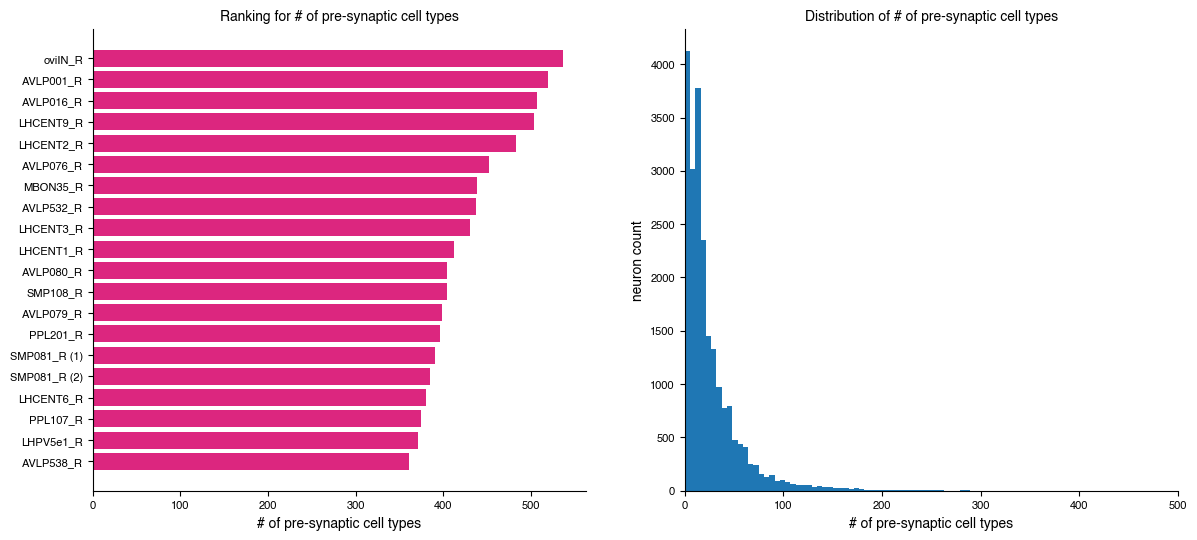

In [54]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(pre_type_rank.head(nn)))
performance = pre_type_rank['n_pre_types'].head(nn)

# preparing names for labels
pre_type_rank_labels = naming_neurons(pre_type_rank.head(nn))

ax[0].barh(y_pos, performance, align='center', color=colors[1])
ax[0].set_yticks(y_pos, labels=pre_type_rank_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of pre-synaptic cell types')
ax[0].set_title('Ranking for # of pre-synaptic cell types')

ax[1].hist(pre_type_rank['n_pre_types'],bins=100)
ax[1].set_xlabel('# of pre-synaptic cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of pre-synaptic cell types')
ax[1].set_xlim(0,500)

plt.show()

### ranking for number of postsynaptic cell types
With a weight threshold of 3 or greater synapses, oviIN ranks 3rd for the most post-synaptic cell types. APL is 193rd, lLN2F_bs are 171st and 198th, DPMs are 653rd and 1683rd.
With no weight threshold, oviINr ranks 23rd for the number of cell types in its post-synaptic partners leaving the others in the dust once again. APL ranks 318, DPMs rank 1229 and 4067, lLN2F_bs rank 704 and 725. 

In [55]:
# sorting by the number of post-synaptic types and finding where oviIN ranks
post_type_rank = all_neurons.sort_values(by='n_post_types',ascending=False,ignore_index=True)
post_type_rank.loc[post_type_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
2,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0


In [56]:
post_type_rank.loc[post_type_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
192,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0


In [57]:
post_type_rank.loc[post_type_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
652,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
1682,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0


In [58]:
post_type_rank.loc[post_type_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
170,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
197,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0


In [59]:
post_type_rank.head(30)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,743.0,338.0,6290.0,2264.0,975.0,17465.0,2501.0,1038.0,23755.0
1,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,373.0,234.0,2905.0,1016.0,756.0,7623.0,1180.0,817.0,10528.0
2,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0
3,1041666949,NaN,NaN,5506,3413,272.0,154.0,1975.0,1125.0,716.0,8625.0,1222.0,742.0,10600.0
4,328533761,PPL201_R,PPL201,4747,8596,631.0,396.0,6341.0,1040.0,672.0,6199.0,1368.0,840.0,12540.0
5,485934965,oviIN_L,oviIN,6542,15998,1030.0,287.0,13388.0,1849.0,583.0,22535.0,2332.0,668.0,35923.0
6,859839499,AVLP532_R,AVLP532,7490,20104,972.0,437.0,17742.0,1082.0,537.0,11936.0,1374.0,617.0,29678.0
7,362473525,AstA1_L,AstA1,4730,6028,431.0,167.0,4144.0,973.0,529.0,9137.0,1298.0,614.0,13281.0
8,859265651,PPL107_R,PPL107,5040,12366,689.0,375.0,10863.0,926.0,529.0,10288.0,1182.0,622.0,21151.0
9,5813057579,AVLP538_R,AVLP538,7502,19336,1021.0,361.0,16968.0,1013.0,512.0,11770.0,1501.0,599.0,28738.0


In [60]:
post_type_rank['n_post_types'].describe()

count    21739.000000
mean        29.404388
std         37.456843
min          0.000000
25%         12.000000
50%         20.000000
75%         34.000000
max        975.000000
Name: n_post_types, dtype: float64

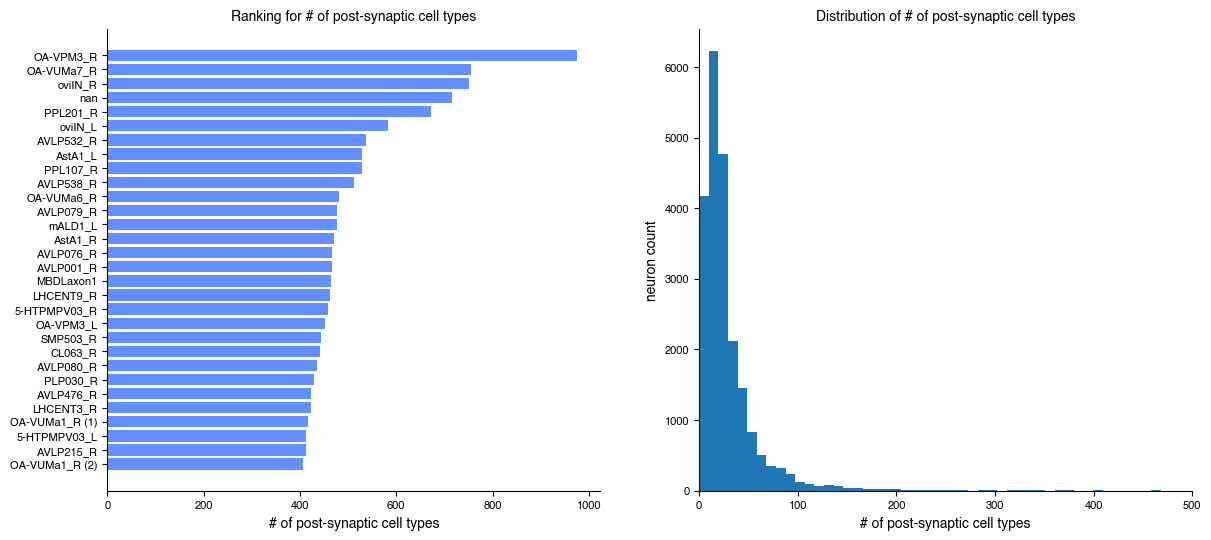

In [61]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 30

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(post_type_rank.head(nn)))
performance = post_type_rank['n_post_types'].head(nn)

# preparing names for labels
post_type_rank_labels = naming_neurons(post_type_rank.head(nn))

ax[0].barh(y_pos, performance, align='center', color=colors[0])
ax[0].set_yticks(y_pos, labels=post_type_rank_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of post-synaptic cell types')
ax[0].set_title('Ranking for # of post-synaptic cell types')

ax[1].hist(post_type_rank['n_post_types'],bins=100)
ax[1].set_xlabel('# of post-synaptic cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of post-synaptic cell types')
ax[1].set_xlim(0,500)

plt.show()

### ranking for total number of partnering cell types
With a weight threshold of 3 or greater synapses, oviIN ranks 2nd for the most partnering cell types. APL is 235th, lLN2F_bs are 317th and 384th, DPMs are 1860th and 4379th.
With no weight threshold, oviINr ranks 15th for the total number of cell types that it makes direct connections with. APL ranks 442, DPMs rank 3452 and 8164, lLN2F_bs rank 1880 and 1993. Including the 'None' types here is valid since the ranking is on an individual neuron basis. There is a None neuron in here that just happens to rank 8th in terms of number of partnering cell types. 

In [31]:
# sorting by the number of total unique synaptic partners types and finding where oviIN ranks
total_type_rank = all_neurons.sort_values(by='n_total_types',ascending=False,ignore_index=True)

In [32]:
# replace the nan types with 'None' string
total_type_rank['type'] = total_type_rank['type'].fillna('None')
total_type_rank['instance'] = total_type_rank['instance'].fillna('None')

In [33]:
total_type_rank.loc[total_type_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0


In [65]:
total_type_rank.loc[total_type_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
234,425790257,APL_R,APL,16190,127151,2666.0,216.0,120684.0,2527.0,184.0,108029.0,2775.0,250.0,228713.0


In [66]:
total_type_rank.loc[total_type_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1859,5813105172,DPM_R,DPM,17628,77269,2250.0,70.0,73373.0,2307.0,105.0,48107.0,2347.0,109.0,121480.0
4378,425276848,DPM_L,DPM,7088,30007,2309.0,42.0,27421.0,1918.0,68.0,19648.0,2475.0,70.0,47069.0


In [67]:
total_type_rank.loc[total_type_rank['type']=='DPM']['n_total_types'].mean()

89.5

In [68]:
total_type_rank.loc[total_type_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
316,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,1774.0,189.0,24400.0,1887.0,191.0,26637.0,2339.0,227.0,51037.0
383,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,1615.0,179.0,23261.0,1825.0,182.0,27304.0,2188.0,210.0,50565.0


In [69]:
total_type_rank.loc[total_type_rank['type']=='lLN2F_b']['n_total_types'].mean()

218.5

In [70]:
total_type_rank.head(16)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,743.0,338.0,6290.0,2264.0,975.0,17465.0,2501.0,1038.0,23755.0
1,423101189,oviIN_R,oviIN,6863,23029,1180.0,536.0,19882.0,1890.0,750.0,27162.0,2460.0,943.0,47044.0
2,328533761,PPL201_R,PPL201,4747,8596,631.0,396.0,6341.0,1040.0,672.0,6199.0,1368.0,840.0,12540.0
3,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,373.0,234.0,2905.0,1016.0,756.0,7623.0,1180.0,817.0,10528.0
4,1041666949,None,None,5506,3413,272.0,154.0,1975.0,1125.0,716.0,8625.0,1222.0,742.0,10600.0
5,330268940,LHCENT9_R,LHCENT9,2654,12428,871.0,503.0,10705.0,721.0,463.0,7023.0,1228.0,707.0,17728.0
6,947573616,AVLP016_R,AVLP016,4740,21382,990.0,507.0,18437.0,643.0,406.0,10199.0,1309.0,685.0,28636.0
7,1321564092,AVLP001_R,AVLP001,4789,17299,1046.0,519.0,14275.0,818.0,466.0,11265.0,1380.0,668.0,25540.0
8,485934965,oviIN_L,oviIN,6542,15998,1030.0,287.0,13388.0,1849.0,583.0,22535.0,2332.0,668.0,35923.0
9,487144598,LHCENT3_R,LHCENT3,3049,11419,707.0,430.0,9354.0,771.0,422.0,8234.0,1208.0,657.0,17588.0


In [71]:
# mean number of total synaptic partner types among all neurons
total_type_rank['n_total_types'].mean()

48.99645797874787

In [72]:
# mode of the number of total synaptic partner types among all neurons
total_type_rank['n_total_types'].mode()

0    25.0
Name: n_total_types, dtype: float64

In [73]:
# summary stats
total_type_rank['n_total_types'].describe()

count    21739.000000
mean        48.996458
std         54.177277
min          0.000000
25%         19.000000
50%         33.000000
75%         61.000000
max       1038.000000
Name: n_total_types, dtype: float64

In [74]:
from scipy import stats

stats.mode(total_type_rank['n_total_types'])

ModeResult(mode=25.0, count=460)

In [75]:
import numpy

numpy.median(total_type_rank['n_total_types'])

33.0

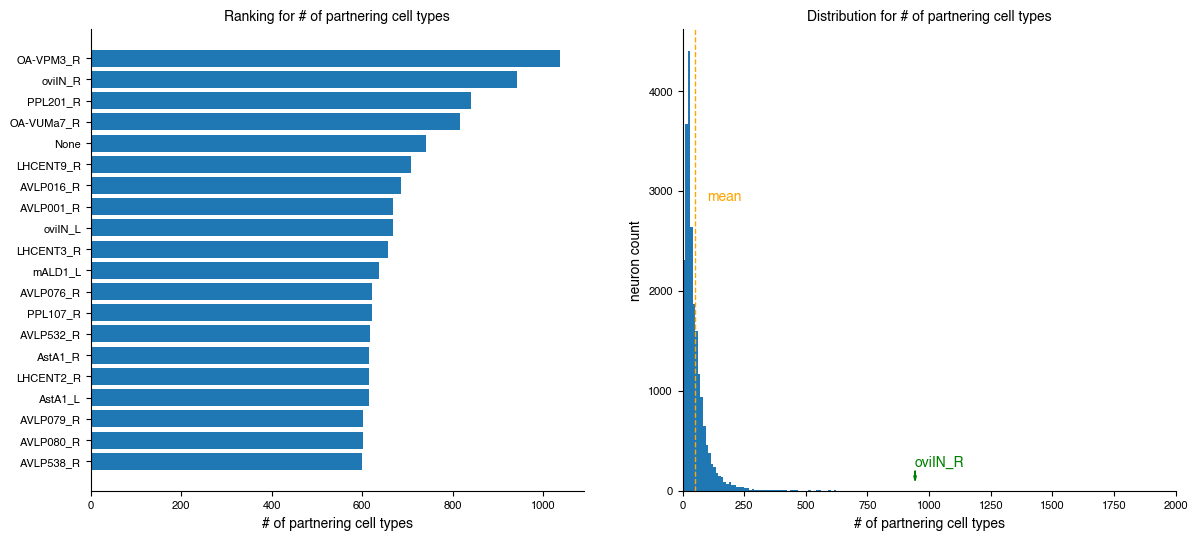

In [76]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_type_rank.head(nn)))
performance = total_type_rank['n_total_types'].head(nn)

# preparing names for labels
total_type_rank_labels = naming_neurons(total_type_rank.head(nn))

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=total_type_rank_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of partnering cell types')
ax[0].set_title('Ranking for # of partnering cell types')

ax[1].hist(total_type_rank['n_total_types'],bins=100)
ax[1].set_xlabel('# of partnering cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution for # of partnering cell types')
ax[1].set_xlim(0,2000)

ax[1].axvline(total_type_rank['n_total_types'].mean(), color='orange', linestyle='dashed', linewidth=1)
ax[1].annotate('mean', xy=(total_type_rank['n_total_types'].mean()+50, 2900), color='orange')
# put an arrow where oviIN is
ax[1].arrow(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 250), color='green')

#plt.savefig('figures/total_types_rank_hbar_hist.pdf', format='pdf')
plt.show()

Creating a stacked bar chart to show pre and post types. Since some cell types can be both pre and post, I will show those as a 3rd color. 

n_pre_types + n_post_types - n_total_types = the double dippers

The double dippers should be subtracted off the n_pre_types and n_post_types to give non-overlapping pre and post types.

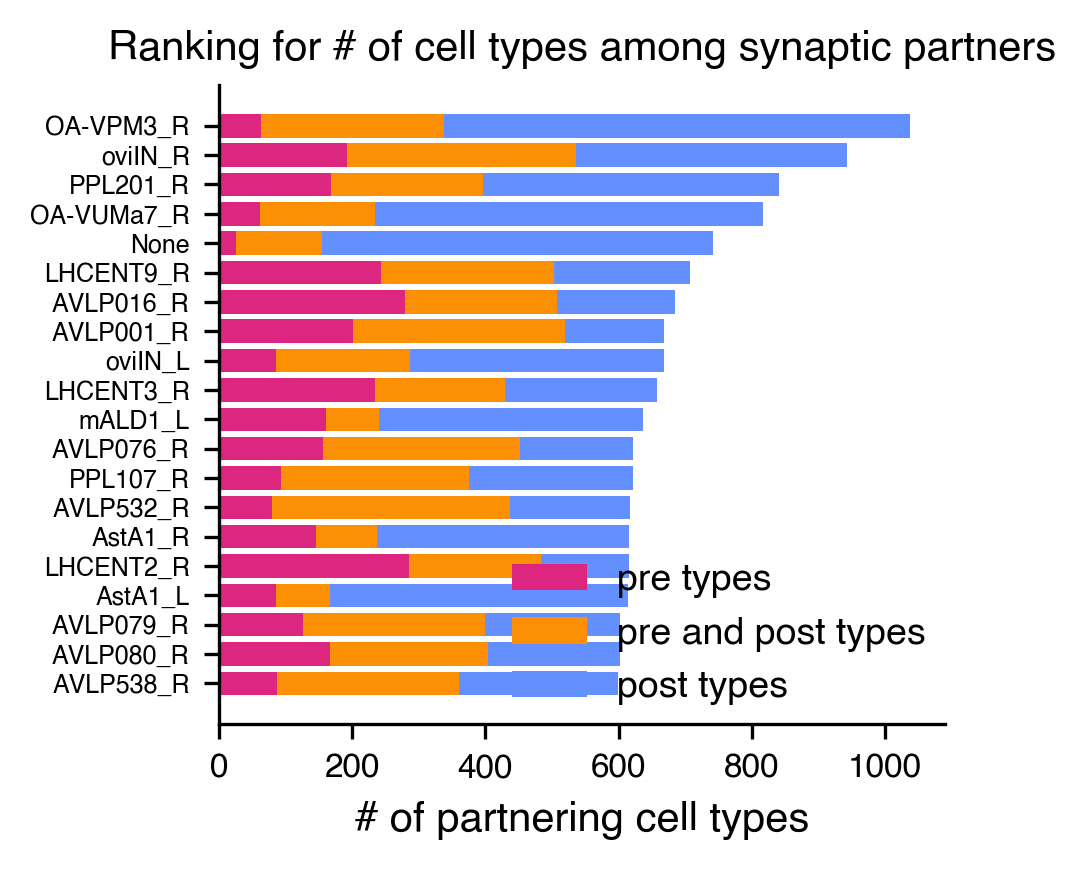

In [38]:
import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots(1,2,figsize=(14,6))
fig, ax = plt.subplots(figsize=(3.35, 3), dpi=300, tight_layout=True)

nn = 20

# grab the data
y_pos = np.arange(len(total_type_rank.head(nn)))
tuniquet = total_type_rank['n_total_types'].head(nn)
pret = total_type_rank['n_pre_types'].head(nn)
postt = total_type_rank['n_post_types'].head(nn)

# change naming convention for the neurons
total_type_rank_labels = naming_neurons(total_type_rank.head(nn))

# calculate the number of double dippers
double_dippers = pret + postt - tuniquet
single_dipper_pre = pret - double_dippers
single_dipper_post = postt - double_dippers

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax.barh(y_pos, single_dipper_pre, align='center', color=colors[1]) # pre-synaptic partners are magenta
ax.barh(y_pos, double_dippers, align='center', left=single_dipper_pre, color=colors[2]) # pre and post-synaptic partners are orange
ax.barh(y_pos, single_dipper_post, align='center', left=single_dipper_pre+double_dippers, color=colors[0]) # post-synaptic partners are periwinkle

ax.set_yticks(y_pos, labels=total_type_rank_labels['name'].head(nn), fontsize=6)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# of partnering cell types')
ax.set_title('Ranking for # of cell types among synaptic partners')
ax.legend(['pre types','pre and post types','post types'], loc='lower right')

#ax[1].hist(total_type_rank['n_total_types'],bins=100)
#ax[1].set_xlabel('# of partnering cell types')
#ax[1].set_ylabel('neuron count')
#ax[1].set_title('Distribution for # of partnering cell types')
#ax[1].set_xlim(0,1000)

#ax[1].axvline(total_type_rank['n_total_types'].mean(), color='red', linestyle='dashed', linewidth=1)
#ax[1].annotate('mean', xy=(total_type_rank['n_total_types'].mean()+50, 2900), color='red')
# put an arrow where oviIN is
#ax[1].arrow(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
#ax[1].annotate('oviIN_R', xy=(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0]-140, 250), color='green')

#plt.savefig('figures/total_types_rank_hbar_stack_hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Synapse rankings
## Synaptic sites
Where oviIN ranks in terms of total number of pre and post sites on it. These seem to be the data that fetch_synapses returns which is fine with me for this part. These are the counts of the pre and post sites on the neuron body. There are generally more post sites than pre because of the polyadic nature of synapses. 

In [78]:
syn_neurons = all_neurons[['bodyId','instance','pre','post']].copy()

### ranking for pre-syn sites

oviIN has the 10th most numerous pre-synaptic sites on it. The right DPM has the most, APL has the 2nd most, and the lLN2F_bs are 4th and 5th.

In [79]:
neurons_pre_sites = syn_neurons.sort_values(by='pre',ascending=False,ignore_index=True)
neurons_pre_sites.loc[neurons_pre_sites['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post
9,423101189,oviIN_R,6863,23029


In [80]:
neurons_pre_sites.head(n=10)

,bodyId,instance,pre,post
0,5813105172,DPM_R,17628,77269
1,425790257,APL_R,16190,127151
2,329566174,OA-VPM3(NO2/NO3)_R,8632,10075
3,5813024698,lLN2F_b(Full)_R,8152,26039
4,1640909284,lLN2F_b(Full)_R,7998,27355
5,5813057579,AVLP538_R,7502,19336
6,859839499,AVLP532_R,7490,20104
7,2124762952,mALC2_L,7281,20985
8,425276848,DPM_L,7088,30007
9,423101189,oviIN_R,6863,23029


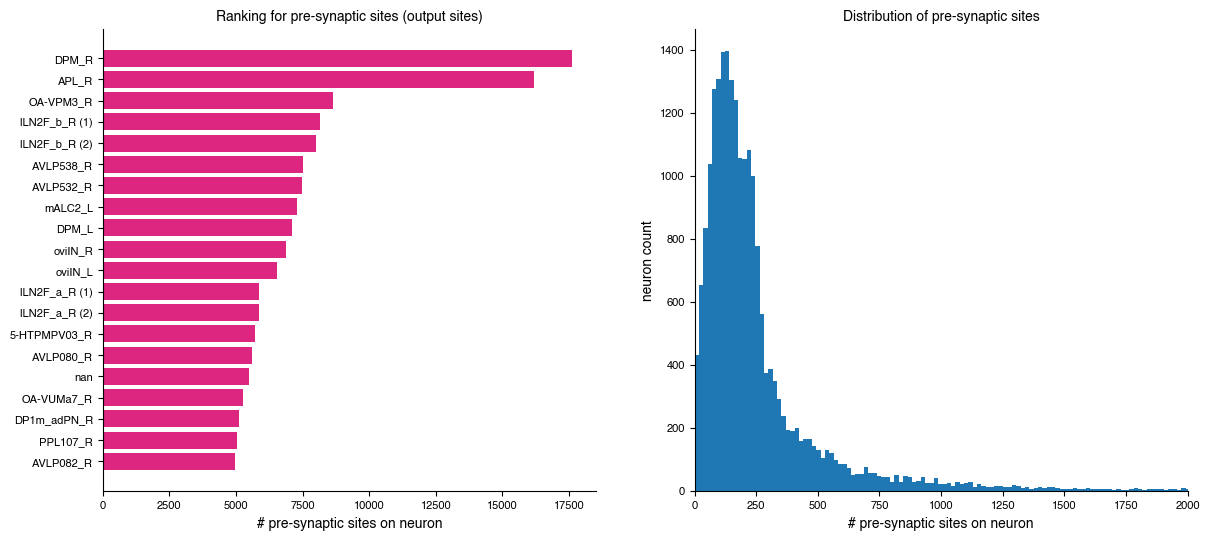

In [81]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(neurons_pre_sites.head(nn)))
performance = neurons_pre_sites['pre'].head(nn)

# preparing names for labels
neurons_pre_sites_labels = naming_neurons(neurons_pre_sites.head(nn))

ax[0].barh(y_pos, performance, align='center', color=colors[1])
ax[0].set_yticks(y_pos, labels=neurons_pre_sites_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# pre-synaptic sites on neuron')
ax[0].set_title('Ranking for pre-synaptic sites (output sites)')

ax[1].hist(neurons_pre_sites['pre'],bins=1000)
ax[1].set_xlabel('# pre-synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of pre-synaptic sites')
ax[1].set_xlim(0,2000)

# put an arrow where oviIN is
ax[1].arrow(neurons_pre_sites[neurons_pre_sites['bodyId']==oviINr_bodyID]['pre'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_pre_sites[neurons_pre_sites['bodyId']==oviINr_bodyID]['pre'].values[0], 250), color='green')

plt.show()

### ranking for post-syn sites

oviIN has the 13th most numerous post-synaptic sites. APL has the most, DPM has the 2nd most, lLN2F_bs have 8th and 10th most. 

In [82]:
neurons_post_sites = syn_neurons.sort_values(by='post',ascending=False,ignore_index=True)
neurons_post_sites.loc[neurons_post_sites['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post
12,423101189,oviIN_R,6863,23029


In [83]:
neurons_post_sites.head(n=15)

,bodyId,instance,pre,post
0,425790257,APL_R,16190,127151
1,5813105172,DPM_R,17628,77269
2,612371421,MBON01(y5B'2a)_R,2208,32544
3,425276848,DPM_L,7088,30007
4,673509195,MBON01(y5B'2a)_L,2205,29244
5,5813039148,PVLP011_R,4693,28662
6,424767514,MBON11(y1pedc>a/B)_R,1646,27642
7,1640909284,lLN2F_b(Full)_R,7998,27355
8,799586652,MBON05(y4>y1y2)(AVM07)_L,1565,27110
9,5813024698,lLN2F_b(Full)_R,8152,26039


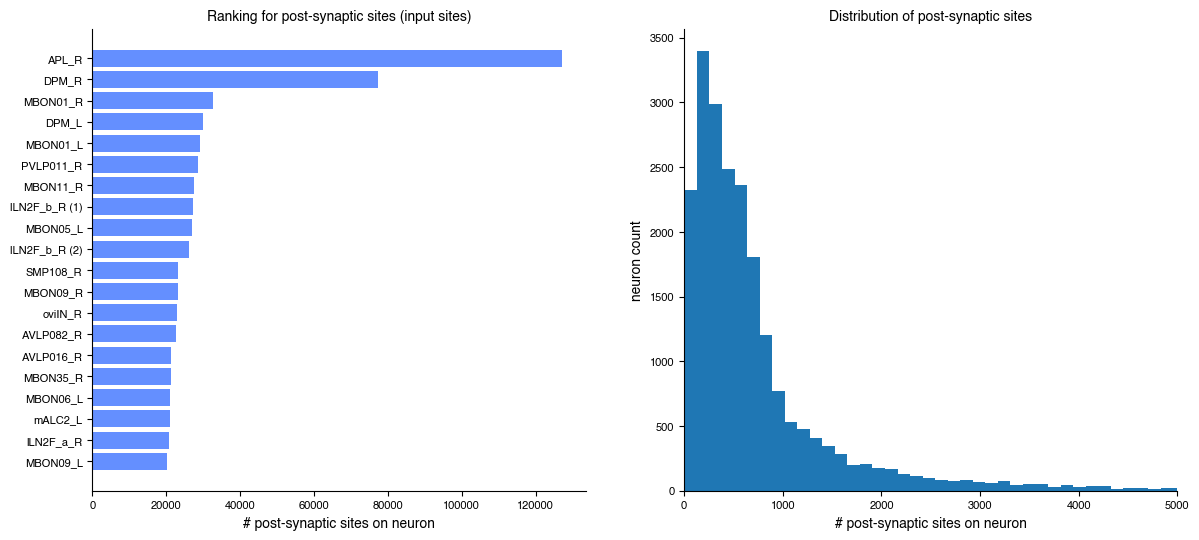

In [84]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(neurons_post_sites.head(nn)))
performance = neurons_post_sites['post'].head(nn)

# preparing names for labels
neurons_post_sites_labels = naming_neurons(neurons_post_sites.head(nn))

ax[0].barh(y_pos, performance, align='center', color=colors[0])
ax[0].set_yticks(y_pos, labels=neurons_post_sites_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# post-synaptic sites on neuron')
ax[0].set_title('Ranking for post-synaptic sites (input sites)')

ax[1].hist(neurons_post_sites['post'],bins=1000)
ax[1].set_xlabel('# post-synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of post-synaptic sites')
ax[1].set_xlim(0,5000)

plt.show()

### ranking for total synaptic sites
Note that there are far fewer pre sites than post sites for most neurons because of polyadic synapses. This count totals the pre and post sites on a given neuron's body which may not be terribly meaningful given the disparity between pre and post sites.

In [85]:
# create a new column to add up all the pre and post site for each neuron
syn_neurons['total_syn_sites'] = syn_neurons.loc[:, ('pre', 'post')].sum(axis=1)
syn_neurons = syn_neurons.sort_values(by='total_syn_sites',ascending=False,ignore_index=True)
syn_neurons

,bodyId,instance,pre,post,total_syn_sites
0,425790257,APL_R,16190,127151,143341
1,5813105172,DPM_R,17628,77269,94897
2,425276848,DPM_L,7088,30007,37095
3,1640909284,lLN2F_b(Full)_R,7998,27355,35353
4,612371421,MBON01(y5B'2a)_R,2208,32544,34752
...,...,...,...,...,...
21734,1409604476,LC20,8,10,18
21735,1077083999,MC61,10,6,16
21736,911815444,OCG09,2,10,12
21737,1003655362,OCG09,1,2,3


In [86]:
syn_neurons['total_syn_sites'].describe()

count     21739.000000
mean       1148.058006
std        2159.706475
min           2.000000
25%         371.000000
50%         685.000000
75%        1140.000000
max      143341.000000
Name: total_syn_sites, dtype: float64

In [87]:
syn_neurons.loc[syn_neurons['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post,total_syn_sites
8,423101189,oviIN_R,6863,23029,29892


oviIN has the 9th most number of total synaptic sites on its body. This may include synaptic sites that are unpartnered or not functional since it is the raw count of sites.
APL has the most, DPMs are 2nd and 3rd, and lLN2F_bs are 4th and 6th.

In [88]:
syn_neurons.head(n=10)

,bodyId,instance,pre,post,total_syn_sites
0,425790257,APL_R,16190,127151,143341
1,5813105172,DPM_R,17628,77269,94897
2,425276848,DPM_L,7088,30007,37095
3,1640909284,lLN2F_b(Full)_R,7998,27355,35353
4,612371421,MBON01(y5B'2a)_R,2208,32544,34752
5,5813024698,lLN2F_b(Full)_R,8152,26039,34191
6,5813039148,PVLP011_R,4693,28662,33355
7,673509195,MBON01(y5B'2a)_L,2205,29244,31449
8,423101189,oviIN_R,6863,23029,29892
9,424767514,MBON11(y1pedc>a/B)_R,1646,27642,29288


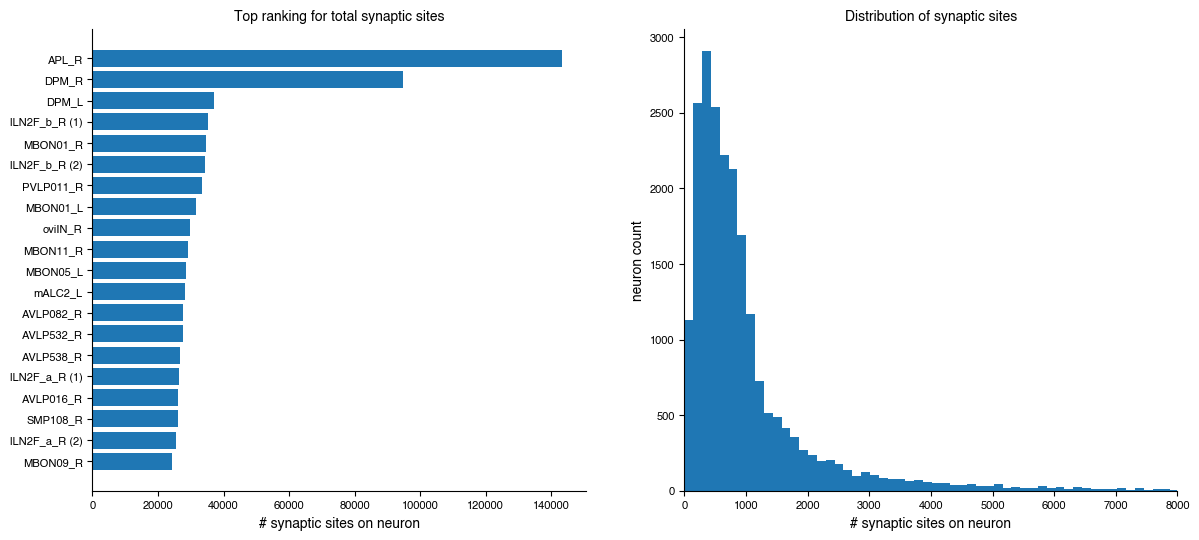

In [89]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(syn_neurons.head(nn)))
performance = syn_neurons['total_syn_sites'].head(nn)

# preparing names for labels
syn_neurons_labels = naming_neurons(syn_neurons.head(nn))

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=syn_neurons_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# synaptic sites on neuron')
ax[0].set_title('Top ranking for total synaptic sites')

ax[1].hist(syn_neurons['total_syn_sites'],bins=1000)
ax[1].set_xlabel('# synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of synaptic sites')
ax[1].set_xlim(0,8000)

#plt.savefig('figures/syn_sites_rank_hbar_hist.pdf', format='pdf')
plt.show()

Total synaptic sites but stacked by pre and post.

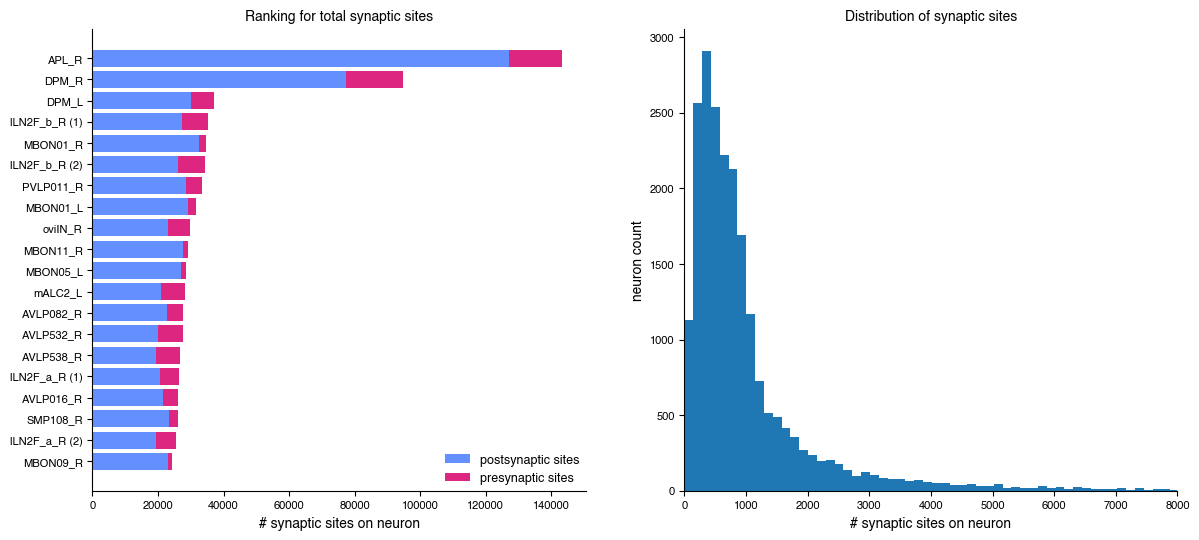

In [90]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(syn_neurons.head(nn)))
performance = syn_neurons['total_syn_sites'].head(nn)
pres = syn_neurons['pre'].head(nn)
posts = syn_neurons['post'].head(nn)

# preparing names for labels
syn_neurons_labels = naming_neurons(syn_neurons.head(nn))

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

#ax[0].barh(y_pos, performance, align='center')
ax[0].barh(y_pos, posts, align='center', color=colors[0])
ax[0].barh(y_pos, pres, align='center', left=posts, color=colors[1])
ax[0].set_yticks(y_pos, labels=syn_neurons_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# synaptic sites on neuron')
ax[0].set_title('Ranking for total synaptic sites')
ax[0].legend(['postsynaptic sites','presynaptic sites'])

ax[1].hist(syn_neurons['total_syn_sites'],bins=1000)
ax[1].set_xlabel('# synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of synaptic sites')
ax[1].set_xlim(0,8000)

#plt.savefig('figures/syn_sites_rank_hbar_hist_stackd.pdf', format='pdf')
plt.show()

Below, I compute the number of synaptic sites divided by each neurons size to get an idea of the density of synaptic sites for the big players. oviIN is not at all impressive in this regard, coming in at 2123rd.

In [91]:
# merge size and synapse dataframes so that I can normalize the synapse counts by size
syn_size_neurons = pd.merge(syn_neurons,size_neurons,on=['bodyId','instance'])
syn_size_neurons

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius
0,425790257,APL_R,16190,127151,143341,23360457066,900.099976
1,5813105172,DPM_R,17628,77269,94897,15191654896,681.000000
2,425276848,DPM_L,7088,30007,37095,6483095365,386.000000
3,1640909284,lLN2F_b(Full)_R,7998,27355,35353,9656560959,741.500000
4,612371421,MBON01(y5B'2a)_R,2208,32544,34752,6839504360,446.500000
...,...,...,...,...,...,...,...
21734,1409604476,LC20,8,10,18,24007823,NaN
21735,1077083999,MC61,10,6,16,28198922,NaN
21736,911815444,OCG09,2,10,12,203180533,236.000000
21737,1003655362,OCG09,1,2,3,144112634,291.000000


In [92]:
# synapse density = total synapse sites / size
syn_size_neurons['syn_density'] = syn_size_neurons['total_syn_sites']/syn_size_neurons['size']
syn_size_neurons = syn_size_neurons.sort_values(by='syn_density',ascending=False,ignore_index=True)

In [93]:
syn_size_neurons.head(n=20)

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
0,364217037,NaN,83,2305,2388,111324878,NaN,0.000021
1,5813067721,MBON14(a3)_L,21,2180,2201,122772402,NaN,0.000018
2,394225044,MBON14(a3)_L,187,5172,5359,359288547,NaN,0.000015
3,1234386037,MBON07(a1)_R,512,15487,15999,1466363330,356.5,0.000011
4,733036127,MBON07(a1)_R,474,15519,15993,1520161953,292.5,0.000011
5,1016835041,MBON09(y3B'1)(AVM17)_L,1291,20281,21572,2083130629,NaN,0.000010
6,1048215779,MBON09(y3B'1)(AVM17)_L,1451,20255,21706,2226046804,NaN,0.000010
7,5813068729,MBON14(a3)_R,738,14387,15125,1564887657,NaN,0.000010
8,5813087625,NaN,208,951,1159,126240451,NaN,0.000009
9,300972942,MBON14(a3)_R,543,13634,14177,1566415099,NaN,0.000009


In [94]:
syn_size_neurons.loc[syn_size_neurons['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
2122,423101189,oviIN_R,6863,23029,29892,10033593370,NaN,0.000003


In [95]:
syn_size_neurons.loc[syn_size_neurons['instance']=='APL_R']

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
48,425790257,APL_R,16190,127151,143341,23360457066,900.099976,0.000006


In [96]:
syn_size_neurons.loc[syn_size_neurons['instance']=='lLN2F_b(Full)_R']

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
954,1640909284,lLN2F_b(Full)_R,7998,27355,35353,9656560959,741.5,0.000004
1099,5813024698,lLN2F_b(Full)_R,8152,26039,34191,9671459921,741.5,0.000004


In [97]:
syn_size_neurons.loc[syn_size_neurons['instance']=='DPM_R']

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
39,5813105172,DPM_R,17628,77269,94897,15191654896,681.0,0.000006


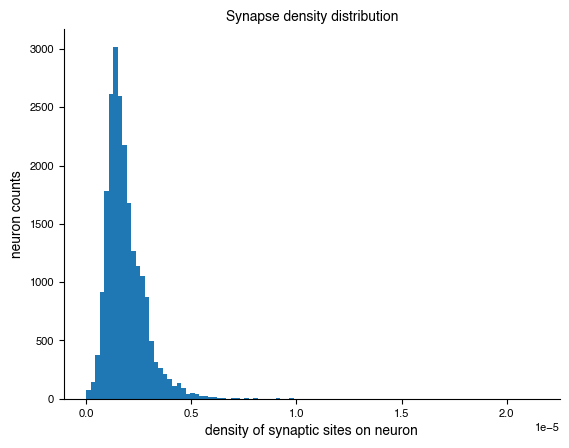

In [98]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
ax.hist(syn_size_neurons['syn_density'], bins=100)

ax.set_title('Synapse density distribution')
ax.set_xlabel('density of synaptic sites on neuron')
ax.set_ylabel('neuron counts')

plt.show()

## Synaptic weights
Instead of using the pre and post sites on the neurons body, I restrict the counts to the connection weights.

In [40]:
synweight_neurons = all_neurons[['bodyId','type','instance','input_weights','output_weights','total_weights']].copy()
synweight_neurons

,bodyId,type,instance,input_weights,output_weights,total_weights
0,200326126,CL141,CL141_L,657.0,841.0,1498.0
1,202916528,FS4C,FS4C(FQ12)_C4_R,228.0,305.0,533.0
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R,187.0,131.0,318.0
3,203253253,SMP505,SMP505(PDM22)_L,2396.0,819.0,3215.0
4,203257652,FS4C,FS4C(FQ12)_C6_R,139.0,186.0,325.0
...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,263.0,326.0,589.0
21735,7112615127,AVLP335,AVLP335_R,340.0,301.0,641.0
21736,7112617294,AVLP331,AVLP331_R,362.0,279.0,641.0
21737,7112622044,LAL137,LAL137(PVL05)_L,1533.0,3587.0,5120.0


### ranking for input weights
oviIN_R ranks 14th for the amount of input weights it gets from presynaptic neurons.

In [100]:
neurons_inweights = synweight_neurons.sort_values(by='input_weights',ascending=False,ignore_index=True)
neurons_inweights.loc[neurons_inweights['bodyId']==oviINr_bodyID]

,bodyId,type,instance,input_weights,output_weights,total_weights
13,423101189,oviIN,oviIN_R,19882.0,27162.0,47044.0


In [101]:
neurons_inweights.head(n=15)

,bodyId,type,instance,input_weights,output_weights,total_weights
0,425790257,APL,APL_R,120684.0,108029.0,228713.0
1,5813105172,DPM,DPM_R,73373.0,48107.0,121480.0
2,612371421,MBON01,MBON01(y5B'2a)_R,30933.0,8532.0,39465.0
3,425276848,DPM,DPM_L,27421.0,19648.0,47069.0
4,673509195,MBON01,MBON01(y5B'2a)_L,27070.0,5813.0,32883.0
5,5813039148,PVLP011,PVLP011_R,26827.0,23193.0,50020.0
6,424767514,MBON11,MBON11(y1pedc>a/B)_R,26016.0,4796.0,30812.0
7,799586652,MBON05,MBON05(y4>y1y2)(AVM07)_L,25535.0,5248.0,30783.0
8,1640909284,lLN2F_b,lLN2F_b(Full)_R,24400.0,26637.0,51037.0
9,5813024698,lLN2F_b,lLN2F_b(Full)_R,23261.0,27304.0,50565.0


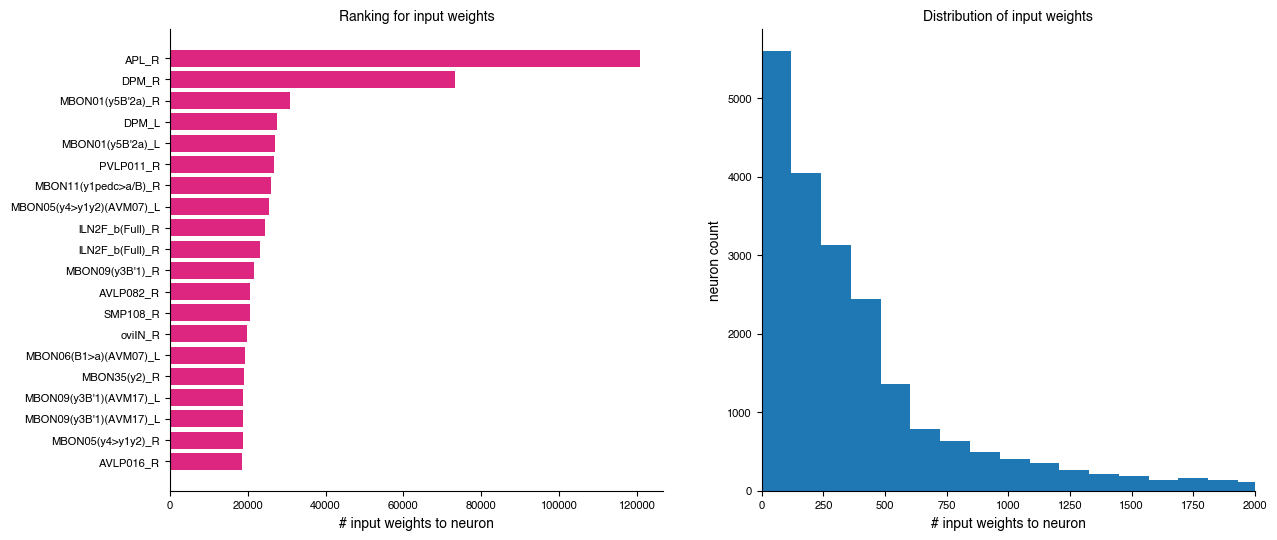

In [102]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(neurons_inweights.head(nn)))
performance = neurons_inweights['input_weights'].head(nn)

# preparing names for labels
neurons_inweights_labels = naming_neurons(neurons_inweights.head(nn))

ax[0].barh(y_pos, performance, align='center', color=colors[1])
ax[0].set_yticks(y_pos, labels=neurons_inweights_labels['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# input weights to neuron')
ax[0].set_title('Ranking for input weights')

ax[1].hist(neurons_inweights['input_weights'],bins=1000)
ax[1].set_xlabel('# input weights to neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of input weights')
ax[1].set_xlim(0,2000)

# put an arrow where oviIN is
ax[1].arrow(neurons_inweights[neurons_inweights['bodyId']==oviINr_bodyID]['input_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_inweights[neurons_inweights['bodyId']==oviINr_bodyID]['input_weights'].values[0], 250), color='green')

plt.show()

### ranking for output weights
oviIN ranks 4th for output weights which is very high. I'm kind of surprised. oviIN might be more interesting for who and how many other neurons it talks to. 

In [103]:
neurons_outweights = synweight_neurons.sort_values(by='output_weights',ascending=False,ignore_index=True)
neurons_outweights.loc[neurons_outweights['bodyId']==oviINr_bodyID]

,bodyId,type,instance,input_weights,output_weights,total_weights
3,423101189,oviIN,oviIN_R,19882.0,27162.0,47044.0


In [104]:
neurons_outweights.head(n=15)

,bodyId,type,instance,input_weights,output_weights,total_weights
0,425790257,APL,APL_R,120684.0,108029.0,228713.0
1,5813105172,DPM,DPM_R,73373.0,48107.0,121480.0
2,5813024698,lLN2F_b,lLN2F_b(Full)_R,23261.0,27304.0,50565.0
3,423101189,oviIN,oviIN_R,19882.0,27162.0,47044.0
4,1640909284,lLN2F_b,lLN2F_b(Full)_R,24400.0,26637.0,51037.0
5,5813039148,PVLP011,PVLP011_R,26827.0,23193.0,50020.0
6,485934965,oviIN,oviIN_L,13388.0,22535.0,35923.0
7,425276848,DPM,DPM_L,27421.0,19648.0,47069.0
8,635062078,DP1m_adPN,DP1m_adPN_R,11979.0,17611.0,29590.0
9,329566174,OA-VPM3,OA-VPM3(NO2/NO3)_R,6290.0,17465.0,23755.0


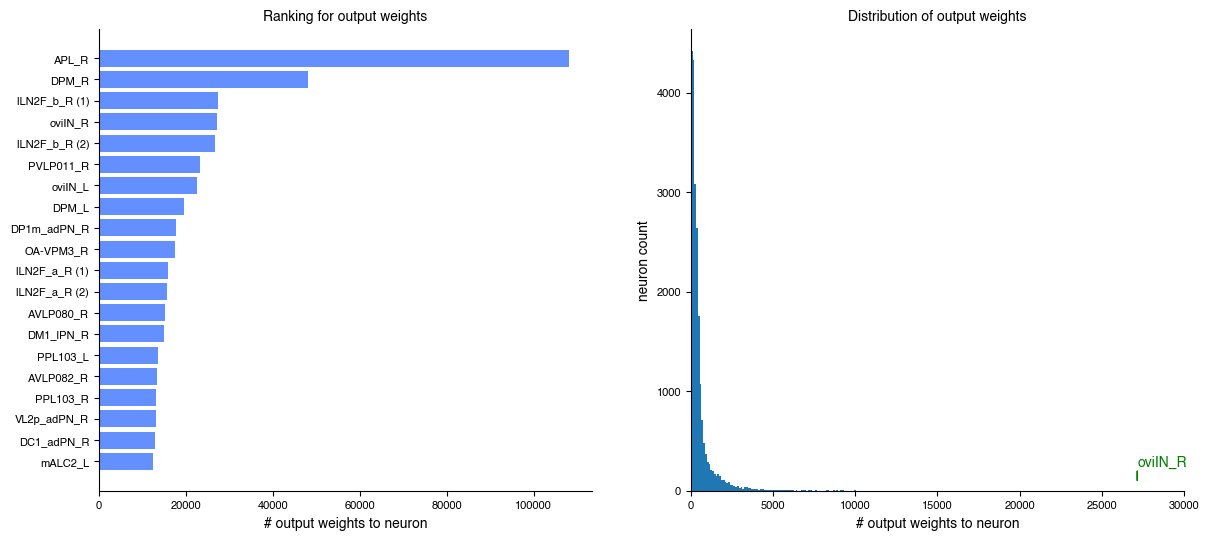

In [105]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

# grab the data
y_pos = np.arange(len(neurons_outweights.head(nn)))
performance = neurons_outweights['output_weights'].head(nn)

# preparing names for labels
neurons_outweights_labels = naming_neurons(neurons_outweights.head(nn))

ax[0].barh(y_pos, performance, align='center', color=colors[0])
ax[0].set_yticks(y_pos, labels=neurons_outweights_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# output weights to neuron')
ax[0].set_title('Ranking for output weights')

ax[1].hist(neurons_outweights['output_weights'],bins=1000)
ax[1].set_xlabel('# output weights to neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of output weights')
ax[1].set_xlim(0,30000)

# put an arrow where oviIN is
ax[1].arrow(neurons_outweights[neurons_outweights['bodyId']==oviINr_bodyID]['output_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_outweights[neurons_outweights['bodyId']==oviINr_bodyID]['output_weights'].values[0], 250), color='green')

plt.show()

### ranking for total weights
oviIN ranks 7th for the total amount of synaptic weights.

In [41]:
neurons_totweights = synweight_neurons.sort_values(by='total_weights',ascending=False,ignore_index=True)
neurons_totweights.loc[neurons_totweights['bodyId']==oviINr_bodyID]

,bodyId,type,instance,input_weights,output_weights,total_weights
6,423101189,oviIN,oviIN_R,19882.0,27162.0,47044.0


In [42]:
neurons_totweights.head(n=15)

,bodyId,type,instance,input_weights,output_weights,total_weights
0,425790257,APL,APL_R,120684.0,108029.0,228713.0
1,5813105172,DPM,DPM_R,73373.0,48107.0,121480.0
2,1640909284,lLN2F_b,lLN2F_b(Full)_R,24400.0,26637.0,51037.0
3,5813024698,lLN2F_b,lLN2F_b(Full)_R,23261.0,27304.0,50565.0
4,5813039148,PVLP011,PVLP011_R,26827.0,23193.0,50020.0
5,425276848,DPM,DPM_L,27421.0,19648.0,47069.0
6,423101189,oviIN,oviIN_R,19882.0,27162.0,47044.0
7,612371421,MBON01,MBON01(y5B'2a)_R,30933.0,8532.0,39465.0
8,485934965,oviIN,oviIN_L,13388.0,22535.0,35923.0
9,5813050499,AVLP082,AVLP082_R,20539.0,13296.0,33835.0


In [43]:
neurons_totweights['total_weights'].describe()

count     21739.000000
mean       1198.079902
std        2804.692092
min           0.000000
25%         285.000000
50%         597.000000
75%        1140.500000
max      228713.000000
Name: total_weights, dtype: float64

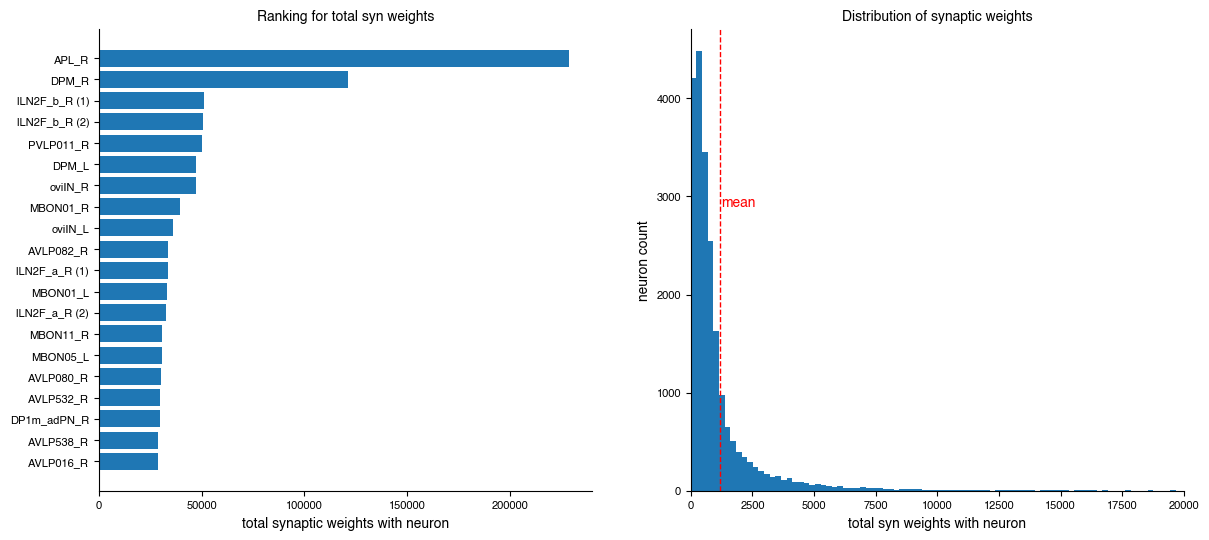

In [109]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_totweights.head(nn)))
performance = neurons_totweights['total_weights'].head(nn)

# preparing names for labels
neurons_totweights_labels = naming_neurons(neurons_totweights.head(nn))

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=neurons_totweights_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('total synaptic weights with neuron')
ax[0].set_title('Ranking for total syn weights')

ax[1].hist(neurons_totweights['total_weights'],bins=1000)
ax[1].set_xlabel('total syn weights with neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of synaptic weights')
ax[1].set_xlim(0,20000)

# indicate the mean
ax[1].axvline(neurons_totweights['total_weights'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[1].annotate('mean', xy=(neurons_totweights['total_weights'].mean()+50, 2900), color='red')

# put an arrow where oviIN is
ax[1].arrow(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 250), color='green')

plt.show()

Creating stacked bar plot that separates input and output weights. This should be easier since these don't overlap.

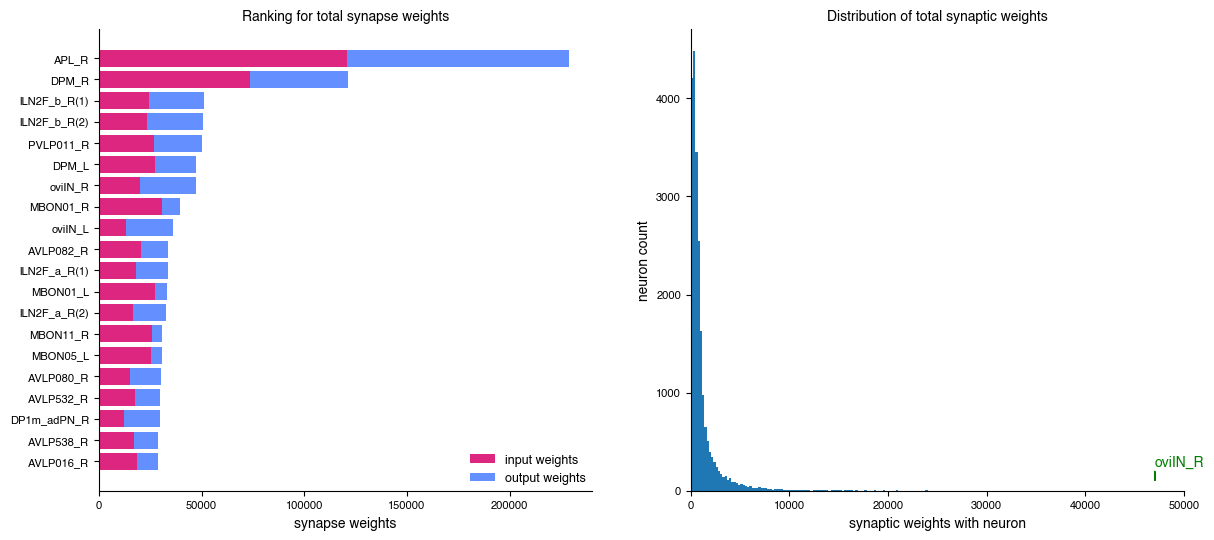

In [44]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_totweights.head(nn)))
inweights = neurons_totweights['input_weights'].head(nn)
outweights = neurons_totweights['output_weights'].head(nn)

# preparing names for labels
neurons_totweights_labels = naming_neurons(neurons_totweights.head(nn))

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax[0].barh(y_pos, inweights, align='center', color=colors[1]) #magenta
ax[0].barh(y_pos, outweights, align='center', left=inweights, color=colors[0]) #periwinkle
ax[0].set_yticks(y_pos, labels=neurons_totweights_labels['name'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('synapse weights')
ax[0].set_title('Ranking for total synapse weights')
ax[0].legend(['input weights','output weights'])

ax[1].hist(neurons_totweights['total_weights'],bins=1000)
ax[1].set_xlabel('synaptic weights with neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of total synaptic weights')
ax[1].set_xlim(0,50000)

# put an arrow where oviIN is
ax[1].arrow(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 250), color='green')

#plt.savefig('figures/syn_weights_rank_hbar_hist_stackd.pdf', format='pdf')
plt.show()

# Big figure

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


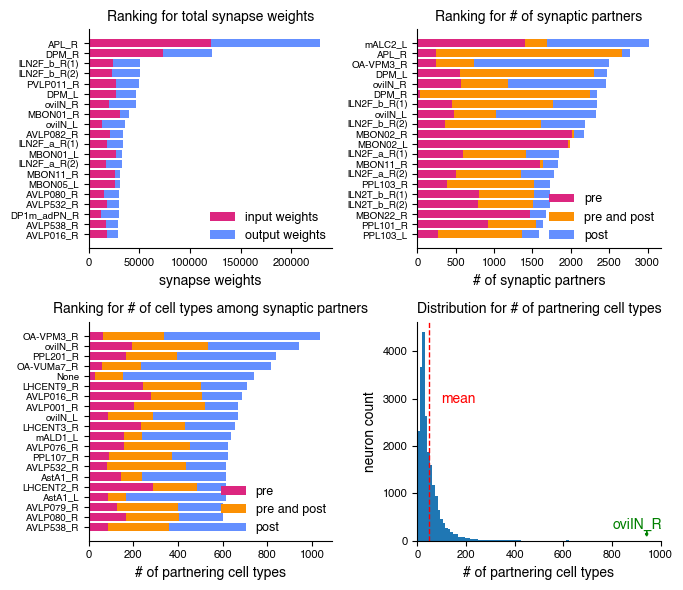

In [47]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,2,figsize=(6.93,6))
#fig, ax = plt.subplots(figsize=(3.35, 3), dpi=300, tight_layout=True)
#fig.set_figwidth(6.93)
yfon = 7
nn = 20

# grab the data
y_pos = np.arange(len(neurons_totweights.head(nn)))
inweights = neurons_totweights['input_weights'].head(nn)
outweights = neurons_totweights['output_weights'].head(nn)

# preparing names for labels
neurons_totweights_labels = naming_neurons(neurons_totweights.head(nn))

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax[0,0].barh(y_pos, inweights, align='center', color=colors[1]) #magenta
ax[0,0].barh(y_pos, outweights, align='center', left=inweights, color=colors[0]) #periwinkle
ax[0,0].set_yticks(y_pos, labels=neurons_totweights_labels['name'].head(nn), fontsize=yfon)
ax[0,0].invert_yaxis()  # labels read top-to-bottom
ax[0,0].set_xlabel('synapse weights')
ax[0,0].set_title('Ranking for total synapse weights')
ax[0,0].legend(['input weights','output weights'])


# grab the data
y_pos = np.arange(len(total_partner_rank.head(nn)))
tuniquep = total_partner_rank['n_total_partners'].head(nn)
postp = total_partner_rank['n_post_partners'].head(nn)
prep = total_partner_rank['n_pre_partners'].head(nn)

# calculate the number of double dippers
double_dippers = prep + postp - tuniquep
single_dipper_pre = prep - double_dippers
single_dipper_post = postp - double_dippers

# change naming convention for the neurons
total_partner_rank_labels = naming_neurons(total_partner_rank.head(nn))

# the color of the bars
colors = ['#648FFF','#DC267F','#FB9004'] # periwinkle, pink, orange

ax[0,1].barh(y_pos, single_dipper_pre, align='center', color=colors[1])
ax[0,1].barh(y_pos, double_dippers, align='center', left=single_dipper_pre, color=colors[2])
ax[0,1].barh(y_pos, single_dipper_post, align='center', left=single_dipper_pre+double_dippers, color=colors[0])
ax[0,1].set_yticks(y_pos, labels=total_partner_rank_labels['name'].head(nn), fontsize=yfon)
ax[0,1].invert_yaxis()  # labels read top-to-bottom
ax[0,1].set_xlabel('# of synaptic partners')
ax[0,1].set_title('Ranking for # of synaptic partners')
#ax[0,1].legend(['pre partners','pre and post partners','post partners'], loc='lower right')
ax[0,1].legend(['pre','pre and post','post'], loc='lower right')

# grab the data
y_pos = np.arange(len(total_type_rank.head(nn)))
tuniquet = total_type_rank['n_total_types'].head(nn)
pret = total_type_rank['n_pre_types'].head(nn)
postt = total_type_rank['n_post_types'].head(nn)

# calculate the number of double dippers
double_dippers = pret + postt - tuniquet
single_dipper_pre = pret - double_dippers
single_dipper_post = postt - double_dippers

# change naming convention for the neurons
total_type_rank_labels = naming_neurons(total_type_rank.head(nn))

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax[1,0].barh(y_pos, single_dipper_pre, align='center', color=colors[1]) # pre-synaptic partners are magenta
ax[1,0].barh(y_pos, double_dippers, align='center', left=single_dipper_pre, color=colors[2]) # pre and post-synaptic partners are orange
ax[1,0].barh(y_pos, single_dipper_post, align='center', left=single_dipper_pre+double_dippers, color=colors[0]) # post-synaptic partners are periwinkle

ax[1,0].set_yticks(y_pos, labels=total_type_rank_labels['name'].head(nn), fontsize=yfon)
ax[1,0].invert_yaxis()  # labels read top-to-bottom
ax[1,0].set_xlabel('# of partnering cell types')
ax[1,0].set_title('Ranking for # of cell types among synaptic partners')
#ax[1,0].legend(['pre types','pre and post types','post types'], loc='lower right')
ax[1,0].legend(['pre','pre and post','post'], loc='lower right')


ax[1,1].hist(total_type_rank['n_total_types'],bins=100)
ax[1,1].set_xlabel('# of partnering cell types')
ax[1,1].set_ylabel('neuron count')
ax[1,1].set_title('Distribution for # of partnering cell types')
ax[1,1].set_xlim(0,1000)

ax[1,1].axvline(total_type_rank['n_total_types'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[1,1].annotate('mean', xy=(total_type_rank['n_total_types'].mean()+50, 2900), color='red')
# put an arrow where oviIN is
ax[1,1].arrow(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1,1].annotate('oviIN_R', xy=(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0]-140, 250), color='green')

fig.tight_layout()
plt.savefig('figures/rankings_hbar_stack_hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Neuropils
The ranking for oviIN in terms of the number of neuropils it makes (pre and post synaptic) connections in since that is the data available. 

In [112]:
all_neurons_rois = neurons_df[['bodyId','instance','type','inputRois','outputRois']].copy()
all_neurons_rois.dtypes

bodyId         int64
instance      object
type          object
inputRois     object
outputRois    object
dtype: object

In [113]:
from neuprint import fetch_primary_rois

# fetching primary ROIs in the full brain
prim_rois = pd.DataFrame(fetch_primary_rois(),columns=['roi'])

In [114]:
prim_rois

,roi
0,AB(L)
1,AB(R)
2,AL(L)
3,AL(R)
4,AME(R)
...,...
58,b'L(R)
59,bL(L)
60,bL(R)
61,gL(L)


In [115]:
# importing supercategories of ROIs
super_cat = pd.read_excel('data/all_roi_df.xlsx')
super_cat

,Super,Super_split,L1,L2,L3,L4,Color,Color2
0,AL,AL(L),AL(L),AL(L),NaN,NaN,cadetblue,NaN
1,AL,NaN,NaN,AL-D(L),NaN,NaN,NaN,cadetblue
2,AL,NaN,NaN,AL-DA2(L),NaN,NaN,NaN,cadetblue
3,AL,NaN,NaN,AL-DA3(L),NaN,NaN,NaN,cadetblue
4,AL,NaN,NaN,AL-DA4m(L),NaN,NaN,NaN,cadetblue
...,...,...,...,...,...,...,...,...
225,VMNP,NaN,NaN,VES(L),NaN,NaN,NaN,firebrick
226,VMNP,NaN,NaN,VES(R),NaN,NaN,NaN,firebrick
227,AL,AL(L),mALT(L),mALT(L),NaN,NaN,cadetblue,NaN
228,AL,AL(R),mALT(R),mALT(R),NaN,NaN,cadetblue,NaN


In [116]:
l2 = super_cat['L2']
super = super_cat['Super']
super_dict = dict(zip(l2, super))
len(set(super))
display(set(super))

{'AL',
 'CX',
 'GC',
 'GF(R)',
 'GNG',
 'INP',
 'LH',
 'LX',
 'MB',
 'NotPrimary',
 'OL',
 'PENP',
 'POC',
 'SNP',
 'VLNP',
 'VMNP'}

In [117]:
super_dict

{'AL(L)': 'AL',
 'AL-D(L)': 'AL',
 'AL-DA2(L)': 'AL',
 'AL-DA3(L)': 'AL',
 'AL-DA4m(L)': 'AL',
 'AL-DC1(L)': 'AL',
 'AL-DC2(L)': 'AL',
 'AL-DC4(L)': 'AL',
 'AL-DL4(L)': 'AL',
 'AL-DL5(L)': 'AL',
 'AL-DM1(L)': 'AL',
 'AL-DM2(L)': 'AL',
 'AL-DM3(L)': 'AL',
 'AL-DM4(L)': 'AL',
 'AL-DM5(L)': 'AL',
 'AL-DM6(L)': 'AL',
 'AL-DP1m(L)': 'AL',
 'AL-VA6(L)': 'AL',
 'AL-VM7d(L)': 'AL',
 'AL-VM7v(L)': 'AL',
 'AL(R)': 'AL',
 'AL-D(R)': 'AL',
 'AL-DA1(R)': 'AL',
 'AL-DA2(R)': 'AL',
 'AL-DA3(R)': 'AL',
 'AL-DA4l(R)': 'AL',
 'AL-DA4m(R)': 'AL',
 'AL-DC1(R)': 'AL',
 'AL-DC2(R)': 'AL',
 'AL-DC3(R)': 'AL',
 'AL-DC4(R)': 'AL',
 'AL-DL1(R)': 'AL',
 'AL-DL2d(R)': 'AL',
 'AL-DL2v(R)': 'AL',
 'AL-DL3(R)': 'AL',
 'AL-DL4(R)': 'AL',
 'AL-DL5(R)': 'AL',
 'AL-DM1(R)': 'AL',
 'AL-DM2(R)': 'AL',
 'AL-DM3(R)': 'AL',
 'AL-DM4(R)': 'AL',
 'AL-DM5(R)': 'AL',
 'AL-DM6(R)': 'AL',
 'AL-DP1l(R)': 'AL',
 'AL-DP1m(R)': 'AL',
 'AL-V(R)': 'AL',
 'AL-VA1d(R)': 'AL',
 'AL-VA1v(R)': 'AL',
 'AL-VA2(R)': 'AL',
 'AL-VA3(R)': 'AL',
 '

In [118]:
# I guess I have to initialize this dataframe column
all_neurons_rois['n_tot_neuropils'] = 0
all_neurons_rois['n_in_neuropils'] = 0
all_neurons_rois['n_out_neuropils'] = 0
all_neurons_rois['n_tot_supercat'] = 0
all_neurons_rois['n_in_supercats'] = 0
all_neurons_rois['n_out_supercats'] = 0
# initialize the supercategories columns for a list of strings
all_neurons_rois['inSuper'] = 0
all_neurons_rois['outSuper'] = 0

# loop through all the neurons and count up the number of unique primary neuropils they make connections with
for i, row in all_neurons_rois.iterrows():
  # obtain total unique neuropils for each neuron
  #in_out_rois_i = row.inputRois.strip("[]").replace("'",'').replace(" ",'').split(',') + row.outputRois.strip("[]").replace("'",'').replace(" ",'').split(',')
  #unique_rois_i = list(set(prim_rois['roi'].tolist()) & set(in_out_rois_i))
  unique_rois_i = list(set(prim_rois['roi'].tolist()) & set(row.inputRois+row.outputRois))
  all_neurons_rois['n_tot_neuropils'][i] = len(unique_rois_i)

  # using the super_dict, i am creating a list of supercategories for each neuron based on the unique_rois_i
  supercats = [super_dict[roi] for roi in unique_rois_i if roi in super_dict]
  all_neurons_rois['n_tot_supercat'][i] = len(set(supercats)) # creating new column

  # obtain unique input neuropils for each neuron
  unique_in_rois_i = list(set(prim_rois['roi'].tolist()) & set(row.inputRois))
  all_neurons_rois['n_in_neuropils'][i] = len(unique_in_rois_i)

  # getting input supercats
  supercats_in = [super_dict[roi] for roi in unique_in_rois_i if roi in super_dict]
  all_neurons_rois['n_in_supercats'][i] = len(set(supercats_in)) # creating new column
  all_neurons_rois['inSuper'][i] = set(supercats_in) # creating new column with the supercats

  # obtain unique output neuropils for each neuron
  unique_out_rois_i = list(set(prim_rois['roi'].tolist()) & set(row.outputRois))
  all_neurons_rois['n_out_neuropils'][i] = len(unique_out_rois_i)

  # getting output supercats
  supercats_out = [super_dict[roi] for roi in unique_out_rois_i if roi in super_dict]
  all_neurons_rois['n_out_supercats'][i] = len(set(supercats_out))
  all_neurons_rois['outSuper'][i] = set(supercats_out) # creating new column with the supercats

all_neurons_rois['n_tot_neuropils'] = all_neurons_rois['n_tot_neuropils'].astype(int)
all_neurons_rois['n_in_neuropils'] = all_neurons_rois['n_in_neuropils'].astype(int)
all_neurons_rois['n_out_neuropils'] = all_neurons_rois['n_out_neuropils'].astype(int)
all_neurons_rois['n_tot_supercat'] = all_neurons_rois['n_tot_supercat'].astype(int)
all_neurons_rois['n_in_supercats'] = all_neurons_rois['n_in_supercats'].astype(int)
all_neurons_rois['n_out_supercats'] = all_neurons_rois['n_out_supercats'].astype(int)
all_neurons_rois

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
0,200326126,CL141_L,CL141,"[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","[AVLP(R), ICL(R), INP, LH(R), MB(+ACA)(R), PLP...",7,7,6,4,4,4,"{SNP, VLNP, INP, LH}","{SNP, VLNP, INP, LH}"
1,202916528,FS4C(FQ12)_C4_R,FS4C,"[CX, FB, FB-column3, FBl1, FBl2, FBl3, FBl4, F...","[CX, FB, FBl7, SMP(L), SNP(L)]",3,3,2,2,2,2,"{CX, SNP}","{CX, SNP}"
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,"[AB(R), CRE(-RUB)(L), CRE(L), CX, FB, FB-colum...","[AB(R), CX, FB, FB-column3, FBl1, FBl7, FBl8, ...",5,5,3,3,3,2,"{SNP, CX, INP}","{CX, SNP}"
3,203253253,SMP505(PDM22)_L,SMP505,"[ATL(L), CRE(-RUB)(L), CRE(L), ICL(L), INP, SC...","[SIP(L), SIP(R), SLP(R), SMP(L), SMP(R), SNP(L...",9,9,5,2,2,1,"{SNP, INP}",{SNP}
4,203257652,FS4C(FQ12)_C6_R,FS4C,"[CX, FB, FBl1, FBl2, FBl3, FBl4, FBl5, FBl6, F...","[SIP(L), SMP(L), SNP(L)]",3,3,2,2,2,1,"{CX, SNP}",{SNP}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,"[LO(R), OL(R), PLP(R), VLNP(R)]","[LO(R), OL(R), PLP(R), VLNP(R)]",2,2,2,2,2,2,"{VLNP, OL}","{VLNP, OL}"
21735,7112615127,AVLP335_R,AVLP335,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]",2,2,2,1,1,1,{VLNP},{VLNP}
21736,7112617294,AVLP331_R,AVLP331,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]",2,2,2,1,1,1,{VLNP},{VLNP}
21737,7112622044,LAL137(PVL05)_L,LAL137,"[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...","[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...",12,11,10,5,5,4,"{LX, MB, SNP, VMNP, INP}","{LX, VMNP, SNP, INP}"


In [119]:
all_neurons_rois = all_neurons_rois.sort_values(by='n_tot_neuropils',ascending=False,ignore_index=True)
all_neurons_rois.head(20)

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
0,1418618235,SIFa(PDM34),SIFa,"[AL(R), AL-D(R), AL-DA1(R), AL-DC1(R), AL-DC3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DC1(...",40,34,39,11,11,11,"{LX, LH, MB, AL, SNP, PENP, VLNP, CX, VMNP, IN...","{LX, LH, MB, AL, SNP, PENP, VLNP, CX, VMNP, IN..."
1,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,"[AL(R), AL-VP2(R), ATL(L), ATL(R), AVLP(R), BU...","[AL(R), AL-VP2(R), AOTU(R), ATL(L), ATL(R), AV...",33,30,31,10,9,9,"{LX, LH, MB, AL, SNP, VLNP, CX, VMNP, INP}","{LX, LH, MB, AL, SNP, PENP, VLNP, CX, INP}"
2,1072063538,DNp27_R,DNp27,"[AME(R), AOT(R), AOTU(R), ATL(L), ATL(R), AVLP...","[AME(R), AOT(R), AOTU(R), ATL(L), ATL(R), AVLP...",31,28,28,8,7,8,"{LX, SNP, PENP, VLNP, VMNP, INP, OL}","{LX, MB, SNP, PENP, VLNP, VMNP, INP, OL}"
3,326253554,SMP454_R,SMP454,"[ATL(R), AVLP(R), CAN(R), CRE(-ROB,-RUB)(R), C...","[AOTU(R), AVLP(R), CRE(-ROB,-RUB)(R), CRE(-RUB...",29,28,16,8,8,4,"{LX, MB, SNP, PENP, VLNP, CX, VMNP, INP}","{VLNP, VMNP, SNP, INP}"
4,5813050455,DNp32_R,DNp32,"[AL(L), AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), ...","[AL(L), AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), ...",29,27,29,10,9,10,"{GNG, LX, LH, AL, SNP, PENP, VLNP, VMNP, INP}","{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, INP}"
5,669325882,5-HTPMPV03_R,5-HTPMPV03,"[AMMC, ATL(L), ATL(R), CAN(R), EPA(R), GNG, GO...","[AMMC, ATL(L), ATL(R), CAN(R), EPA(R), GNG, GO...",28,27,27,9,9,9,"{GNG, LX, LH, SNP, PENP, VLNP, VMNP, INP, OL}","{GNG, LX, LH, SNP, PENP, VLNP, VMNP, INP, OL}"
6,1501392572,PS088_R,PS088,"[AMMC, AOTU(R), ATL(L), ATL(R), CAN(R), EPA(L)...","[AMMC, AOTU(R), ATL(L), ATL(R), CAN(R), EPA(L)...",28,28,26,7,7,7,"{GNG, LX, SNP, PENP, VLNP, VMNP, INP}","{GNG, LX, SNP, PENP, VLNP, VMNP, INP}"
7,791527493,5-HTPMPV03_L,5-HTPMPV03,"[AME(R), AMMC, ATL(L), ATL(R), CAN(R), EPA(R),...","[AME(R), AMMC, ATL(L), ATL(R), CAN(R), EPA(R),...",28,27,28,9,9,9,"{GNG, LX, LH, SNP, PENP, VLNP, VMNP, INP, OL}","{GNG, LX, LH, SNP, PENP, VLNP, VMNP, INP, OL}"
8,1534270924,VES041_R,VES041,"[AOTU(R), ATL(L), ATL(R), CAN(R), CRE(-ROB,-RU...","[AOTU(R), ATL(L), ATL(R), CRE(-ROB,-RUB)(R), C...",28,28,21,6,6,5,"{LX, SNP, PENP, VLNP, VMNP, INP}","{LX, SNP, VLNP, VMNP, INP}"
9,484130600,SMP145_R,SMP145,"[ATL(L), ATL(R), AVLP(R), CA(R), CRE(-ROB,-RUB...","[AL(R), ATL(L), ATL(R), BU(R), CA(R), CRE(-ROB...",28,25,26,8,7,8,"{LX, LH, MB, SNP, VLNP, VMNP, INP}","{LX, LH, MB, AL, SNP, VLNP, VMNP, INP}"


In [120]:
all_neurons_rois_super = all_neurons_rois.sort_values(by='n_tot_supercat',ascending=False,ignore_index=True)
all_neurons_rois_super.head(20)

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
0,1418618235,SIFa(PDM34),SIFa,"[AL(R), AL-D(R), AL-DA1(R), AL-DC1(R), AL-DC3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DC1(...",40,34,39,11,11,11,"{LX, LH, MB, AL, SNP, PENP, VLNP, CX, VMNP, IN...","{LX, LH, MB, AL, SNP, PENP, VLNP, CX, VMNP, IN..."
1,767473384,OA-VPM4,OA-VPM4,"[AL(R), AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), CX...","[AL(R), AL-VP2(R), AVLP(R), CRE(-ROB,-RUB)(R),...",23,21,23,11,10,11,"{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, CX, INP}","{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, CX, VMN..."
2,699031185,SIFa(PDM34),SIFa,"[AB(R), AL(R), AL-D(R), AL-DA2(R), AL-DC1(R), ...","[AB(R), AL(R), AL-D(R), AL-DA2(R), AL-DC1(R), ...",26,24,21,11,11,9,"{GNG, LX, LH, MB, AL, SNP, VLNP, CX, VMNP, INP...","{GNG, LH, MB, AL, SNP, CX, VMNP, INP, OL}"
3,544038123,mALD1_L,mALD1,"[AL(R), AOTU(R), ATL(R), AVLP(R), CRE(-ROB,-RU...","[AOTU(R), ATL(R), AVLP(R), CRE(-ROB,-RUB)(R), ...",24,24,17,11,11,7,"{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, I...","{LX, LH, SNP, VLNP, VMNP, INP, OL}"
4,5813054053,OA-ASM3_R,OA-ASM3,"[AL(R), AVLP(R), CX, EPA(L), EPA(R), FB, FBl8,...","[AL(R), AVLP(R), EPA(L), EPA(R), GC, GNG, GOR(...",28,28,25,11,11,8,"{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, CX, VMN...","{GNG, LX, AL, SNP, PENP, VLNP, VMNP, INP}"
5,642723975,mALB2_L,mALB2,"[AL(R), AL-VP2(R), AMMC, AVLP(R), CRE(-ROB,-RU...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), INP, LAL(...",16,16,9,10,10,5,"{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, INP}","{LX, LH, SNP, VLNP, INP}"
6,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,"[AL(R), AL-VP2(R), ATL(L), ATL(R), AVLP(R), BU...","[AL(R), AL-VP2(R), AOTU(R), ATL(L), ATL(R), AV...",33,30,31,10,9,9,"{LX, LH, MB, AL, SNP, VLNP, CX, VMNP, INP}","{LX, LH, MB, AL, SNP, PENP, VLNP, CX, INP}"
7,611323175,mALB1_L,mALB1,"[AL(R), AL-VC5(R), AL-VP1d(R), AL-VP2(R), AL-V...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), GA(R), IN...",20,20,14,10,10,8,"{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, INP}","{LX, LH, MB, SNP, PENP, VLNP, VMNP, INP}"
8,639585968,LHCENT11_R,LHCENT11,"[AL(R), AVLP(R), BU(R), CRE(-ROB,-RUB)(R), CRE...","[AL(R), AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), EP...",21,21,17,10,10,10,"{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, INP}","{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, INP}"
9,5813050455,DNp32_R,DNp32,"[AL(L), AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), ...","[AL(L), AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), ...",29,27,29,10,9,10,"{GNG, LX, LH, AL, SNP, PENP, VLNP, VMNP, INP}","{GNG, LX, LH, MB, AL, SNP, PENP, VLNP, VMNP, INP}"


In [121]:
all_neurons_rois.loc[all_neurons_rois['bodyId']==oviINr_bodyID]

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
404,423101189,oviIN_R,oviIN,"[ATL(R), CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(...","[CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",14,14,12,5,5,5,"{LX, SNP, PENP, VMNP, INP}","{LX, SNP, PENP, VMNP, INP}"


In [122]:
set(all_neurons_rois.loc[all_neurons_rois['bodyId']==oviINr_bodyID].inputRois.values[0]) & set(prim_rois['roi'].tolist())

{'ATL(R)',
 'CAN(R)',
 'CRE(L)',
 'CRE(R)',
 'FLA(R)',
 'GOR(R)',
 'IB',
 'LAL(R)',
 'SIP(L)',
 'SIP(R)',
 'SMP(L)',
 'SMP(R)',
 'SPS(R)',
 'VES(R)'}

In [123]:
display(all_neurons_rois.loc[all_neurons_rois['type']=='oviIN'])
display(all_neurons_rois_super.loc[all_neurons_rois_super['type']=='oviIN'])

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
404,423101189,oviIN_R,oviIN,"[ATL(R), CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(...","[CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",14,14,12,5,5,5,"{LX, SNP, PENP, VMNP, INP}","{LX, SNP, PENP, VMNP, INP}"
803,485934965,oviIN_L,oviIN,"[ATL(L), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...","[ATL(L), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",12,12,12,4,4,4,"{LX, VMNP, SNP, INP}","{LX, VMNP, SNP, INP}"


,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
1521,423101189,oviIN_R,oviIN,"[ATL(R), CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(...","[CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",14,14,12,5,5,5,"{LX, SNP, PENP, VMNP, INP}","{LX, SNP, PENP, VMNP, INP}"
4423,485934965,oviIN_L,oviIN,"[ATL(L), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...","[ATL(L), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",12,12,12,4,4,4,"{LX, VMNP, SNP, INP}","{LX, VMNP, SNP, INP}"


oviINr ranks 404th for the number of neuropils it interacts with, but this doesn't mean much given that there are many neurons that interact with the same number of neuropils.

oviINr ranks 1521 for the number of supercategories of neuropils it interacts with, this also doesn't mean much as the oviINr is prety centralized in the INP.

In [124]:
all_neurons_rois[400:410]

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
400,5813082722,CRE021(ADM06)_L,CRE021,"[CRE(-RUB)(L), CRE(L), CX, EPA(L), EPA(R), GOR...","[CRE(-RUB)(L), CRE(L), EPA(L), EPA(R), GOR(L),...",14,13,12,7,6,6,"{LX, MB, SNP, CX, VMNP, INP}","{LX, MB, SNP, VLNP, VMNP, INP}"
401,5813062161,AVLP470_R,AVLP470,"[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), GOR(L), G...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), GOR(L), G...",14,14,13,4,4,4,"{VLNP, VMNP, SNP, INP}","{VLNP, VMNP, SNP, INP}"
402,5813078074,SMP585_R,SMP585,"[CRE(-ROB,-RUB)(R), CRE(R), FLA(R), GNG, GOR(L...","[GNG, GOR(R), IPS(R), SMP(R), SNP(R), VES(R), ...",14,14,5,6,6,3,"{GNG, SNP, PENP, VLNP, VMNP, INP}","{GNG, VMNP, SNP}"
403,1043700892,AVLP369_R,AVLP369,"[AVLP(R), EPA(R), GOR(L), GOR(R), IB, ICL(R), ...","[AVLP(R), EPA(R), GOR(L), GOR(R), IB, ICL(R), ...",14,14,13,5,5,5,"{LX, SNP, VLNP, VMNP, INP}","{LX, SNP, VLNP, VMNP, INP}"
404,423101189,oviIN_R,oviIN,"[ATL(R), CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(...","[CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",14,14,12,5,5,5,"{LX, SNP, PENP, VMNP, INP}","{LX, SNP, PENP, VMNP, INP}"
405,735091236,ALIN3_R,ALIN3,"[AL(R), AL-VC5(R), AL-VP1d(R), AL-VP1m(R), AL-...","[AL(L), AL(R), AL-VC2(R), AL-VC5(R), AL-VP1d(R...",14,13,6,7,7,4,"{LH, AL, SNP, PENP, VLNP, VMNP, INP}","{VLNP, VMNP, AL, PENP}"
406,915520244,CL336_R,CL336,"[CAN(R), CRE(-ROB,-RUB)(R), CRE(R), GOR(R), IB...","[CRE(-ROB,-RUB)(R), CRE(R), GOR(R), IB, ICL(R)...",14,14,10,7,7,5,"{LX, MB, SNP, PENP, VLNP, VMNP, INP}","{MB, SNP, VLNP, VMNP, INP}"
407,455129365,SIP086_R,SIP086,"[BU(R), CRE(-ROB,-RUB)(R), CRE(R), EPA(R), GNG...","[CRE(-ROB,-RUB)(R), CRE(R), EPA(R), INP, LAL(-...",14,14,8,6,6,5,"{LX, GNG, SNP, VLNP, VMNP, INP}","{LX, SNP, VLNP, VMNP, INP}"
408,5813064485,PS119(PDM16)_L,PS119,"[AVLP(R), CAN(R), IB, ICL(L), ICL(R), INP, PEN...","[AVLP(R), IB, ICL(L), ICL(R), INP, SCL(L), SCL...",14,14,12,5,5,4,"{SNP, PENP, VLNP, VMNP, INP}","{VLNP, VMNP, SNP, INP}"
409,2222406094,VES035_R,VES035,"[AVLP(R), GOR(L), GOR(R), IB, ICL(R), INP, LAL...","[AVLP(R), GOR(L), IB, ICL(L), ICL(R), INP, LAL...",14,13,12,6,6,6,"{LX, SNP, PENP, VLNP, VMNP, INP}","{LX, SNP, PENP, VLNP, VMNP, INP}"


However, the vast majority of neurons interact with fewer than 10 neuropils and around 4 supercategories, so oviIN is pretty exceptional.

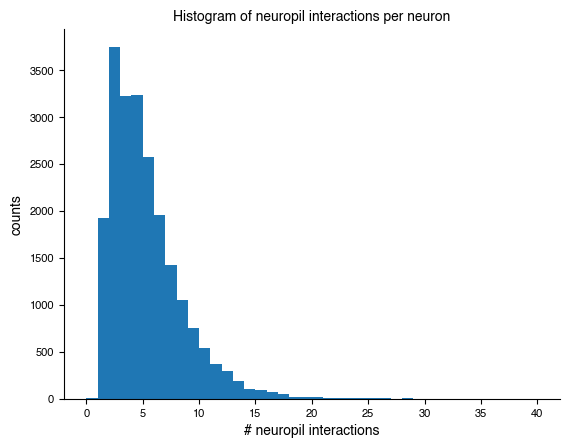

In [125]:
import matplotlib.pyplot as plt

# histogram of neuropil interactions
plt.hist(all_neurons_rois['n_tot_neuropils'],bins=all_neurons_rois['n_tot_neuropils'].max())
plt.title("Histogram of neuropil interactions per neuron")
plt.xlabel("# neuropil interactions")
plt.ylabel("counts")
plt.show()

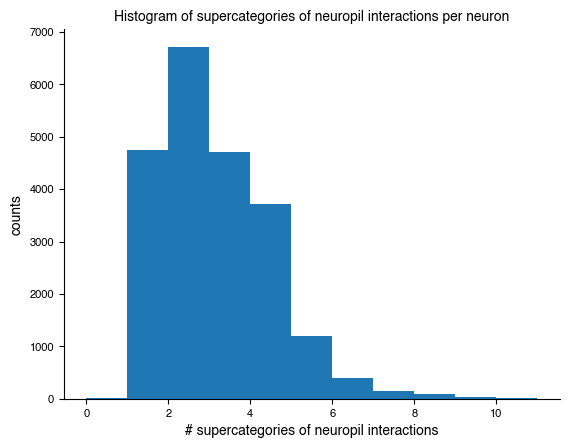

In [126]:
# histogram for supercategories of neuropil interactions
plt.hist(all_neurons_rois['n_tot_supercat'],bins=all_neurons_rois['n_tot_supercat'].max())
plt.title("Histogram of supercategories of neuropil interactions per neuron")
plt.xlabel("# supercategories of neuropil interactions")
plt.ylabel("counts")
plt.show()

Meanwhile, APL interacts with 21 neuropils and 5 supercategories - which is much more than I expected. DPMs interact with 7 and 11 neuropils , lLN2F_bs interact with 2 and 4. 

These numbers have changed since rerunning this analysis. I don't know what I could've changed to lead to different results. (R- this happened to me too, but when I ran it again from the start of the file some of the numbers were changed back...)

In [127]:
display(all_neurons_rois.loc[all_neurons_rois['type']=='APL'])
all_neurons_rois_super.loc[all_neurons_rois_super['type']=='APL']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
26,425790257,APL_R,APL,"[AL(R), AL-VP2(R), ATL(L), ATL(R), AVLP(R), CA...","[AL(R), AL-VP2(R), ATL(L), CA(R), CRE(-ROB,-RU...",24,24,18,7,7,5,"{LX, LH, MB, AL, SNP, VLNP, INP}","{MB, AL, SNP, VLNP, INP}"


,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
137,425790257,APL_R,APL,"[AL(R), AL-VP2(R), ATL(L), ATL(R), AVLP(R), CA...","[AL(R), AL-VP2(R), ATL(L), CA(R), CRE(-ROB,-RU...",24,24,18,7,7,5,"{LX, LH, MB, AL, SNP, VLNP, INP}","{MB, AL, SNP, VLNP, INP}"


In [128]:
display(all_neurons_rois.loc[all_neurons_rois['type']=='DPM'])
all_neurons_rois_super.loc[all_neurons_rois_super['type']=='DPM']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
500,5813105172,DPM_R,DPM,"[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), ICL(R), I...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), ICL(R), I...",13,13,12,5,5,4,"{LX, MB, SNP, VLNP, INP}","{VLNP, MB, SNP, INP}"
1336,425276848,DPM_L,DPM,"[CRE(-RUB)(L), CRE(L), INP, MB(+ACA)(R), MB(L)...","[CRE(-RUB)(L), CRE(L), INP, MB(+ACA)(R), MB(L)...",10,10,7,3,3,3,"{MB, SNP, INP}","{SNP, MB, INP}"


,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
1426,5813105172,DPM_R,DPM,"[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), ICL(R), I...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), ICL(R), I...",13,13,12,5,5,4,"{LX, MB, SNP, VLNP, INP}","{VLNP, MB, SNP, INP}"
8081,425276848,DPM_L,DPM,"[CRE(-RUB)(L), CRE(L), INP, MB(+ACA)(R), MB(L)...","[CRE(-RUB)(L), CRE(L), INP, MB(+ACA)(R), MB(L)...",10,10,7,3,3,3,"{MB, SNP, INP}","{SNP, MB, INP}"


In [129]:
all_neurons_rois.loc[all_neurons_rois['type']=='lLN2F_b']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils,n_tot_supercat,n_in_supercats,n_out_supercats,inSuper,outSuper
12687,5813024698,lLN2F_b(Full)_R,lLN2F_b,"[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...",4,4,4,4,4,4,"{VLNP, LX, VMNP, AL}","{VLNP, LX, VMNP, AL}"
18870,1640909284,lLN2F_b(Full)_R,lLN2F_b,"[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...",2,2,2,2,2,2,"{VMNP, AL}","{VMNP, AL}"


In [130]:
# summary stats
all_neurons_rois['n_tot_neuropils'].describe()

count    21739.000000
mean         4.809375
std          3.239753
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         40.000000
Name: n_tot_neuropils, dtype: float64

On average, a neuron in the Hemibrain connects to 4.7 neuropils.

In [131]:
# summary stats for supercategories
all_neurons_rois['n_tot_supercat'].describe()

count    21739.000000
mean         2.644418
std          1.371230
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         11.000000
Name: n_tot_supercat, dtype: float64

On average, a neuron connects to 2.6 out of 16 supercategories in the hemibrain. The oviINr connects in 5 out of 16 supercategories of neuropils in the brain.

The oviINr connects to 1.9 times as many supercategories of neuropils than the average neurons in the hemibrain.